# Introduction

Here we aim to understand predictions of grid cells as a compression (e.g. non-negative sparse pca) of place cell activity.


In [1]:
## Setup ##
from GridModels.code.models import vel2pc_RNN as v2p
v2p.options.n_steps = 100000 #long trajectory for maximal coverage
v2p.options.place_cell_rf = 0.12
navigation_activity_df = v2p.generate_navigation_rates_df(v2p.options)

navigation_activity_df

Using device: cuda


100%|██████████| 100000/100000 [02:24<00:00, 693.38it/s]


time centroid_position            velocity            \
                                   x         y         x         y   
0         0.016667          0.561679  1.424697 -0.007887 -0.082475   
1         0.033333          0.561549  1.423314 -0.007813 -0.082991   
2         0.050000          0.561429  1.421867 -0.007195 -0.086825   
3         0.066667          0.561322  1.420460 -0.006372 -0.084413   
4         0.083333          0.561230  1.418997 -0.005553 -0.087784   
...            ...               ...       ...       ...       ...   
99995  1666.600000          0.912068  0.817918 -0.012864  0.057993   
99996  1666.616667          0.911853  0.819057 -0.012921  0.068342   
99997  1666.633333          0.911660  0.820094 -0.011542  0.062205   
99998  1666.650000          0.911411  0.821497 -0.014978  0.084211   
99999  1666.666667          0.911216  0.822942 -0.011697  0.086682   

      head_direction                          firingrate                ...  \
                   x         y     degrees  place_cell_0  place_cell_1  ...   
0          -0.110930 -0.993828  -96.368920 -5.113653e-16 -7.575830e-16  ...   
1          -0.109020 -0.994040  -96.258843 -5.442658e-16 -8.063903e-16  ...   
2          -0.106087 -0.994357  -96.089789 -5.807643e-16 -8.605581e-16  ...   
3          -0.102667 -0.994716  -95.892796 -6.184519e-16 -9.165092e-16  ...   
4          -0.098282 -0.995159  -95.640230 -6.600072e-16 -9.782329e-16  ...   
...              ...       ...         ...           ...           ...  ...   
99995      -0.314129  0.949380  108.308266 -2.808809e-10 -7.300532e-10  ...   
99996      -0.300128  0.953899  107.465281 -2.746238e-10 -7.134450e-10  ...   
99997      -0.287260  0.957853  106.693991 -2.690139e-10 -6.985665e-10  ...   
99998      -0.274980  0.961450  105.960818 -2.615111e-10 -6.786927e-10  ...   
99999      -0.259552  0.965729  105.043511 -2.535664e-10 -6.577370e-10  ...   

                                                                   \
      place_cell_502 place_cell_503 place_cell_504 place_cell_505   
0           0.725976  -1.297099e-10      -0.000006      -0.016168   
1           0.728630  -1.366052e-10      -0.000007      -0.016499   
2           0.731345  -1.441939e-10      -0.000007      -0.016852   
3           0.733890  -1.519604e-10      -0.000007      -0.017201   
4           0.736479  -1.604601e-10      -0.000007      -0.017572   
...              ...            ...            ...            ...   
99995      -0.001469  -1.104572e-04      -0.000185      -0.121325   
99996      -0.001502  -1.085035e-04      -0.000184      -0.121276   
99997      -0.001532  -1.067457e-04      -0.000184      -0.121224   
99998      -0.001574  -1.043894e-04      -0.000184      -0.121142   
99999      -0.001617  -1.019200e-04      -0.000183      -0.121051   

                                                                   \
      place_cell_506 place_cell_507 place_cell_508 place_cell_509   
0      -1.821859e-16  -2.925305e-11  -1.194790e-08  -6.965251e-14   
1      -1.930394e-16  -3.051935e-11  -1.233088e-08  -7.341391e-14   
2      -2.051344e-16  -3.191151e-11  -1.274850e-08  -7.758310e-14   
3      -2.176469e-16  -3.333089e-11  -1.317028e-08  -8.187265e-14   
4      -2.315289e-16  -3.488450e-11  -1.362824e-08  -8.660576e-14   
...              ...            ...            ...            ...   
99995  -1.571704e-05  -7.665537e-03  -4.923776e-02  -3.695259e-04   
99996  -1.525463e-05  -7.530667e-03  -4.881892e-02  -3.603520e-04   
99997  -1.484544e-05  -7.409945e-03  -4.844049e-02  -3.521951e-04   
99998  -1.430926e-05  -7.249923e-03  -4.793502e-02  -3.414496e-04   
99999  -1.378288e-05  -7.092566e-03  -4.744673e-02  -3.308346e-04   

                                     
      place_cell_510 place_cell_511  
0           0.444286  -8.159593e-11  
1           0.453616  -8.542677e-11  
2           0.463393  -8.964335e-11  
3           0.472913  -9.395100e-11  
4           0.482823  -9.867031e-11  
...          

## Position Encoding Lagrangean 

Here we look at grid cells under the lens of pattern formation theory for the position encoding problem. Here we follow Sorscher et al. 2019.

$$\mathcal{E}(G,W) = \mid \mid P- \hat{P} \mid\mid^2_F, \qquad \hat{P}=GW $$

- $P\in \mathbb{R}^{n_x\times n_P}$ denotes place cell activations for different positions, such that $P_{x,i}$ is the activity of place cell $i$ at location $x$. 
- $G\in \mathbb{R}^{n_x\times n_G}$ denotes grid cell activations, such that $G_{x,j}$ is the activity of grid cell $j$ at location $x$.
- $W \in \mathbb{R}^n_G\times n_P$ represents readout weights, such that $W_{j,i}$ is the contribution of grid cell $j$ to place cell $i$ activity predictions.
- $\hat{P}\in \mathbb{R}^{n_x\times n_P}$ denotes predicted place cell activations.


Since we care mostly about $G$, we assume that $W$ is optimal for a fixed $G$:
$$ W := \text{argmin}_W \mathcal{E}(G,W) \approx (G^T G)^{-1}G^T P$$
noting that with some matrix algebra this implies
$$ W \approx G^{-1}(G^{T})^{-1} G^T P =  G^{-1} P \implies GW=\hat{P}$$

Now there's some more matrix hacks: the objective $\mathcal{E}$ is the same under linear transformations, so we can simplify it by a transformation $Z$ so that $G$ has orthonormal columns:

$$G\to GZ, W\to Z^{-1}W$$

which can be enforced via Lagrange multipliers:
$$ \mathcal{L}=\text{Tr} [G^T \sum G - \lambda(G^TG-I)], \qquad \sum=PP^T$$


In [ ]:
#get place cell activity matrix P #
from GridModels.code.measures import spatial
from GridModels.code.models import pattern_formation as pf
import numpy as np
import matplotlib.pyplot as plt
pos = navigation_activity_df.centroid_position.values
rates = navigation_activity_df.firingrate.values
ratemaps, binx, biny = spatial.get_2D_ratemaps(rates, pos, 
                                               x_size = 0.05, 
                                               y_size = 0.05)

print(f'{round(np.mean(np.isnan(ratemaps))*100,4)} % of bins unoccupied')
ratemaps[np.isnan(ratemaps)] = 1e-6 # set NaN to very small value. Seems to work? But probably wont for maze data
P = ratemaps.reshape(ratemaps.shape[0],ratemaps.shape[1]*ratemaps.shape[2]).T # (n_positions,n_place_cells)


1.0702 % of bins unoccupied


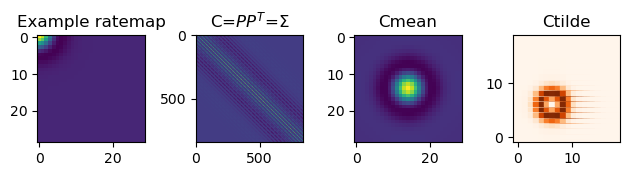

In [4]:
## Sorscher et al. 2023 replication ##
import matplotlib.pyplot as plt
import numpy as np
from GridModels.code.models import pattern_formation as pf

# we can get a view of covariance matrices also in fourier space
C, Cmean, Ctilde = pf.get_covariance_matrices(P, verbose=True)

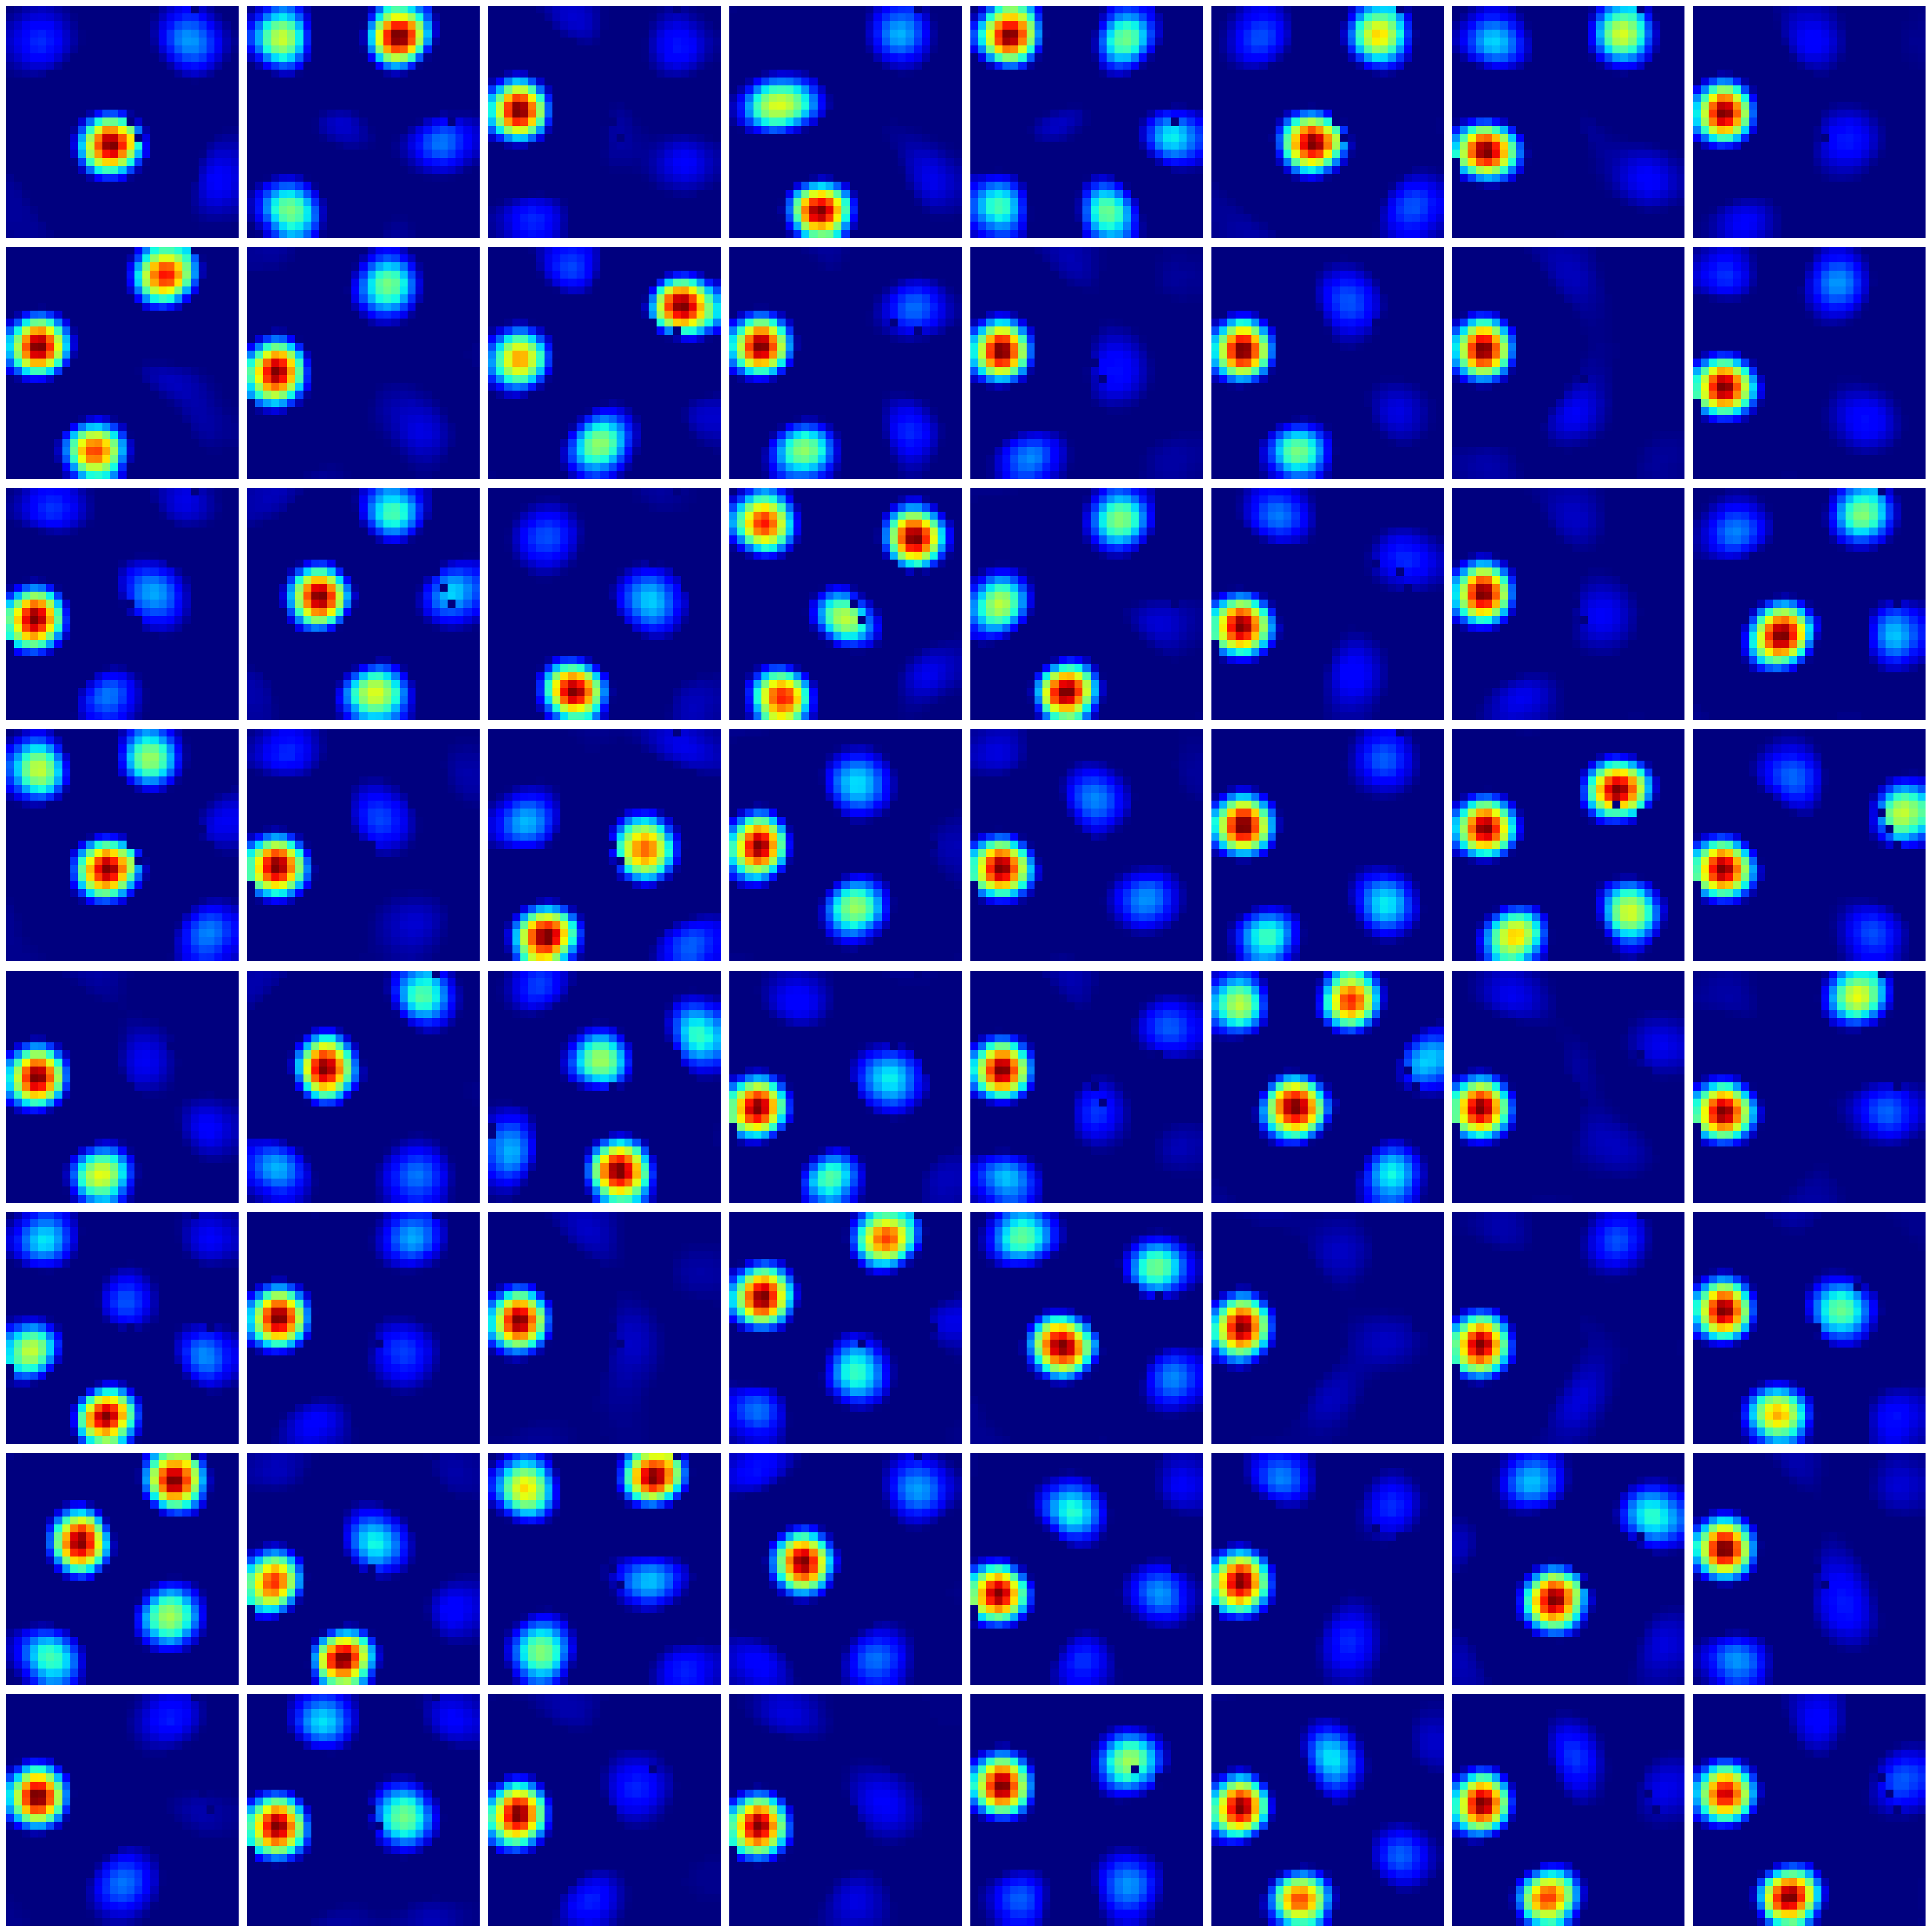

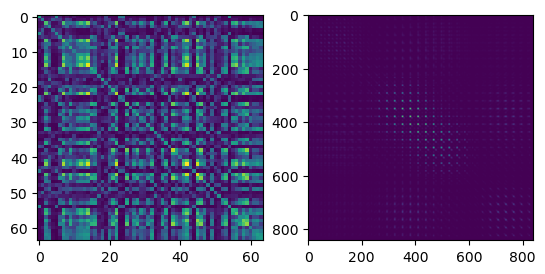

100%|██████████| 64/64 [00:00<00:00, 79.04it/s]


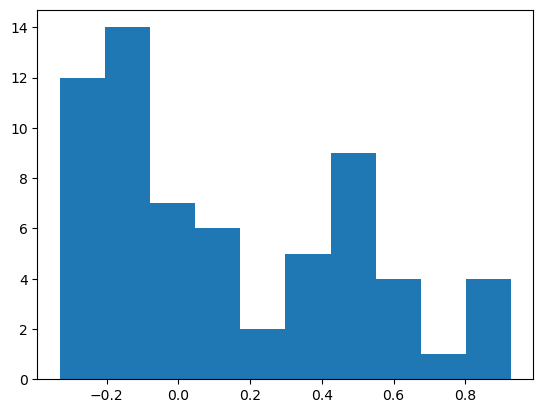

In [26]:
# Direct Lagrangian solution, gradient ascent

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

## SET THE NUMBER OF GRID CELLS ## 
Ng = 64

res = ratemaps.shape[1]
n_plot_rows = int(np.sqrt(Ng))
shifted_P = (P - P.mean(axis=1).reshape(-1,1))
normalised_P = (P/P.max(axis=1).reshape(-1,1))
positionsXplace_cells = shifted_P

results_dict = pf.optimize_lagrangean(positionsXplace_cells,Ng, 
                                  learning_rate = 3e-2,
                                  n_iterations = 1000,
                                  verbose = False)

G = results_dict['G']
fig, ax = plt.subplots(n_plot_rows,Ng//n_plot_rows, 
                            figsize = (4*Ng//n_plot_rows,4*n_plot_rows))
for i, axis in enumerate(ax.flatten()):
    axis.imshow(G[:,i].reshape(res,res), cmap = 'jet')
    axis.axis('off')
fig.tight_layout()
plt.show()#


#Lack of diversity in constraint is due to lacking orthogonality.
# somehow not really reaching the GTG = I constraint
fig, ax = plt.subplots(1,2)
G_normalised = G/G.mean(axis=0).reshape(1,-1)
ax[0].imshow(G_normalised.T@G_normalised) #this should be I
ax[1].imshow(G_normalised@G_normalised.T) #this should span multiple places, not just a single one.
plt.show()

## Grid scoring ## 
from tqdm import tqdm
from GridModels.code.measures import grid_scorer as gscoring

G_as_ratemaps = G.T.reshape(Ng,res,res)
G_as_ratemaps = G_as_ratemaps/G_as_ratemaps.mean(axis=(1,2)).reshape(G_as_ratemaps.shape[0],1,1)

grid_scores, sacs = gscoring.get_grid_scores(G_as_ratemaps, binx, biny)
plt.hist(grid_scores)
plt.show()

C_norm min: 0.0, max: 1.0
W shape: (841, 64), H shape: (64, 841)


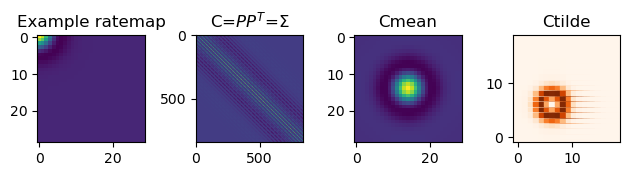

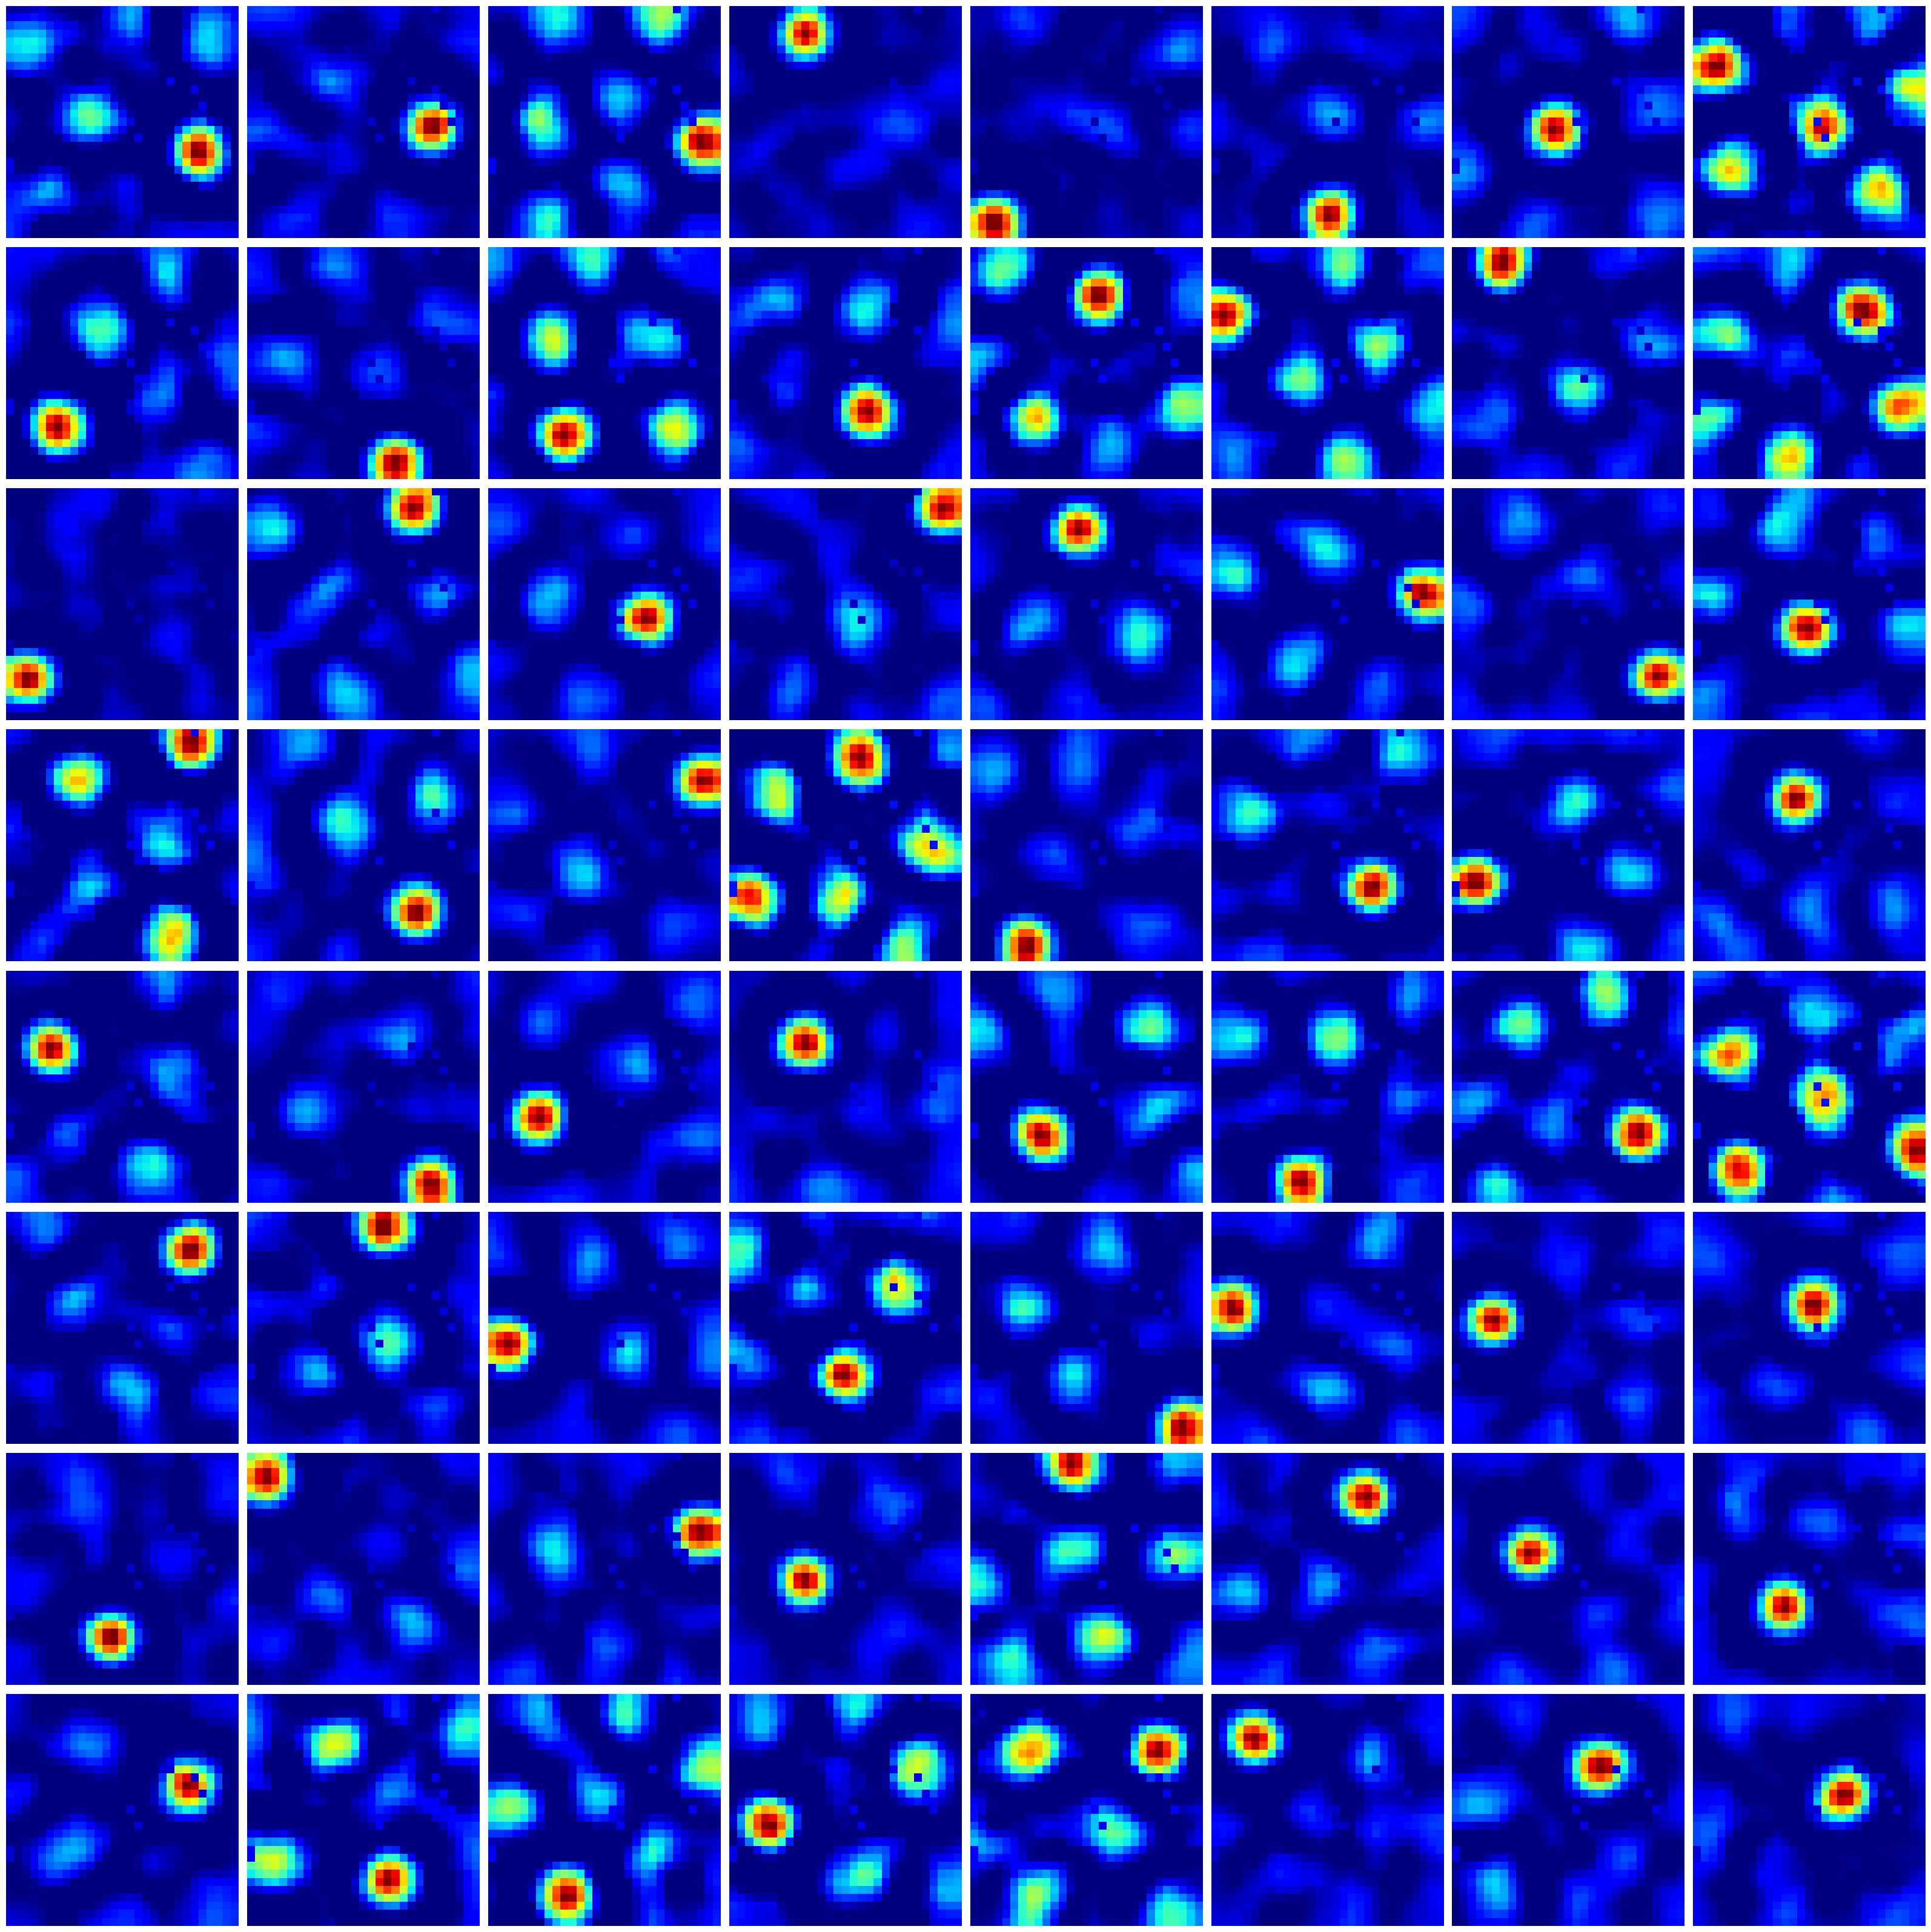

 25%|██▌       | 16/64 [00:00<00:00, 78.71it/s]

In [ ]:
# Standard NMF implementations
from sklearn.decomposition import NMF

C, Cmean, Ctilde = pf.get_covariance_matrices(P, verbose=True)

Ng = 64  # choose the number of components you want
n_plot_rows = int(np.sqrt(Ng))

C_min = C.min()
C_max = C.max()
C_norm = (C - C_min) / (C_max - C_min)
print(f"C_norm min: {C_norm.min()}, max: {C_norm.max()}")

# Perform non-negative matrix factorisation on C_norm
nmf = NMF(n_components=Ng, 
          init='random', 
          beta_loss = 'kullback-leibler', solver = 'mu',
          random_state=0, 
          max_iter=1000)
W = nmf.fit_transform(C_norm)
H = nmf.components_
print(f"W shape: {W.shape}, H shape: {H.shape}")

fig, ax = plt.subplots(n_plot_rows,Ng//n_plot_rows, 
                            figsize = (4*Ng//n_plot_rows,4*n_plot_rows))
for i, axis in enumerate(ax.flatten()):
    axis.imshow(H[i].reshape(res,res), cmap = 'jet')
    axis.axis('off')
fig.tight_layout()
plt.show()

## Grid scoring ## 

H_as_ratemaps = H.reshape(Ng,res,res)
grid_scores, sacs = gscoring.get_grid_scores(H_as_ratemaps, binx, biny)
plt.hist(grid_scores)


Using device: cuda
Starting grid search over 2 combinations...

Combination 1/2: λ_ortho=10.0000, λ_sparse=0.0010, λ_activity=1.0000, lr=0.0100
🌟 New best! Error: 3317.699858

Combination 2/2: λ_ortho=10.0000, λ_sparse=0.0010, λ_activity=1.0000, lr=0.1000
🌟 New best! Error: 315.462076

Grid search completed!
Best recon error: 315.462076
Best hyperparameters: {'lambda_ortho': 10, 'lambda_sparse': 0.001, 'lr': 0.1}

=== BEST RESULT SUMMARY ===
Reconstruction error: 315.462076
Hyperparameters: lambda_ortho=10, lambda_sparse=0.001, lr=0.1


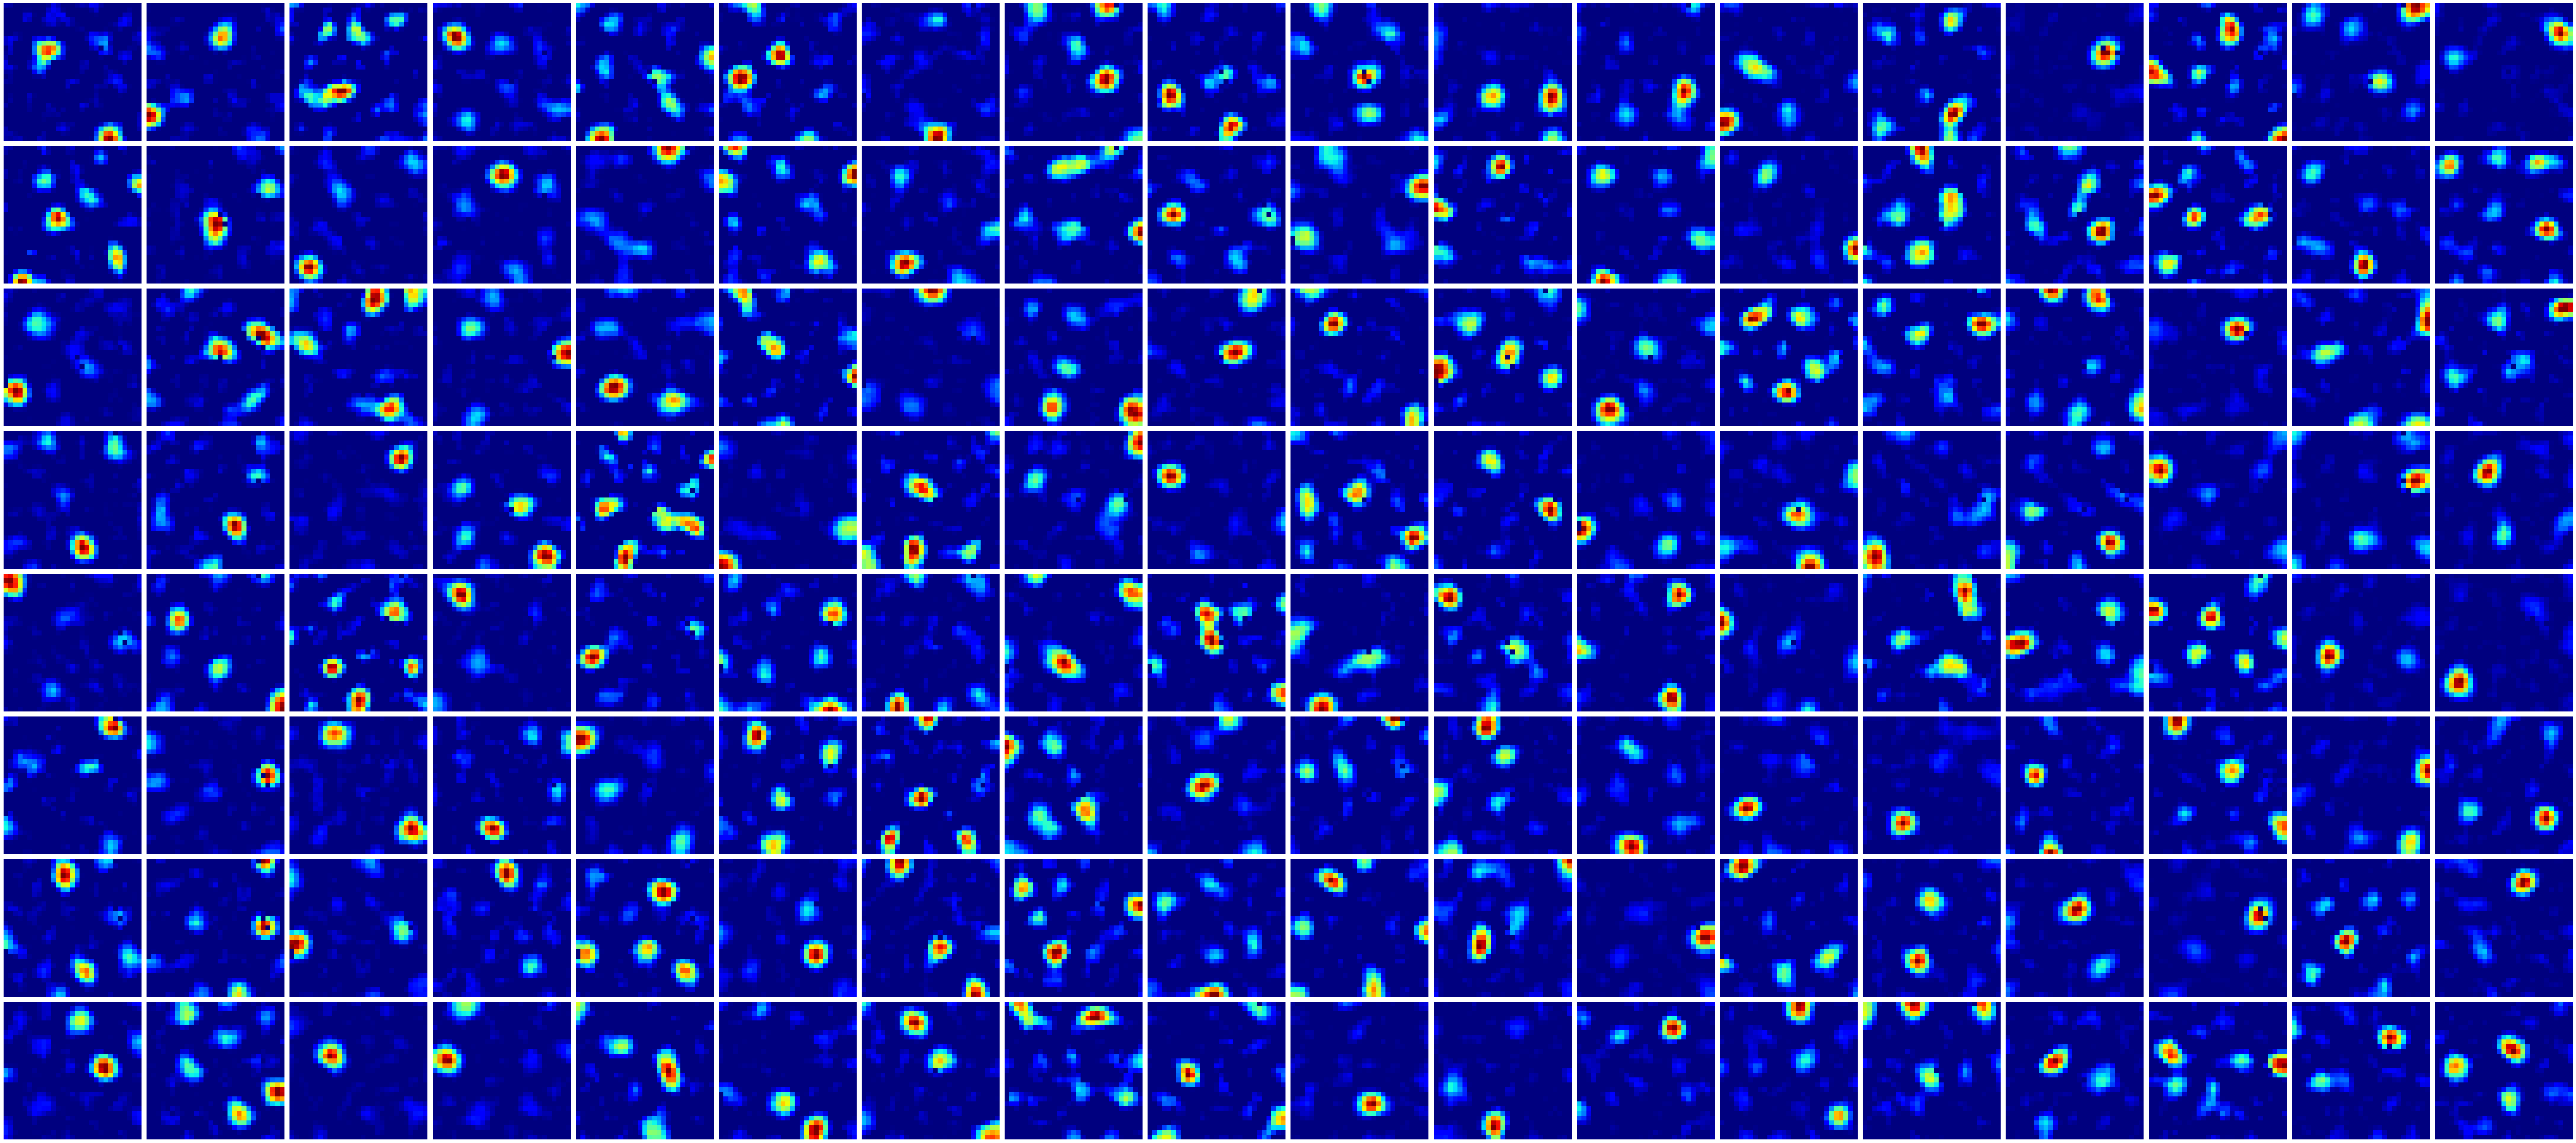

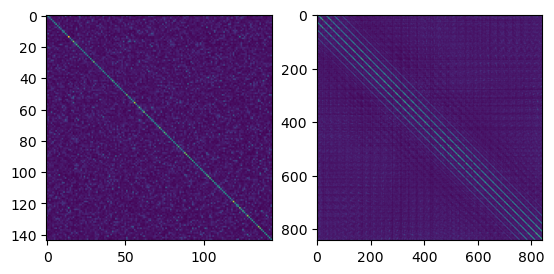

100%|██████████| 144/144 [00:01<00:00, 78.89it/s]


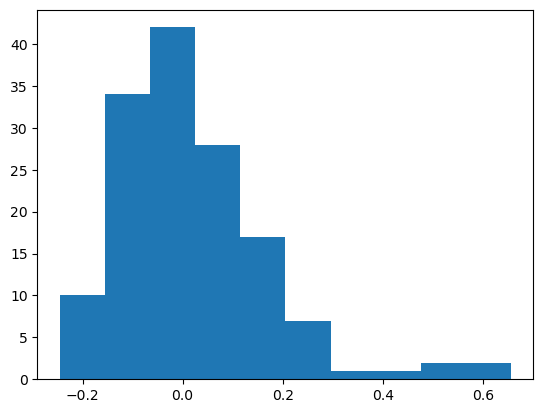

In [105]:
# pytorch autograd attempt #
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from itertools import product

def optimize_position_encoding(P, Ng, ortho=False, sparse=False, nonneg=False,
                               activity_constrained = False, 
                               lambda_ortho=1.0, lambda_sparse=0.1, lambda_activity = 0.01,
                               lr=0.01, epochs=1000, device='cpu', verbose=True):
    """
    Optimize grid cell activations (G) and readout weights (W) for position encoding.
    
    Returns:
        G, W, final_recon_error
    """
    n_x, n_P = P.shape
    P = P.to(device)
    
    # Initialize parameters
    G = nn.Parameter(torch.randn(n_x, Ng, device=device))
    W = nn.Parameter(torch.randn(Ng, n_P, device=device))
    I = torch.eye(Ng, device=device)
    optimizer = optim.AdamW([G, W], weight_decay = 0,amsgrad=True, lr=lr)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Apply constraints
        if nonneg:
            G.data = torch.relu(G.data)
            
        # Forward pass
        P_hat = G @ W
        reconstruction_loss = torch.norm(P - P_hat, p='fro')**2
        loss = reconstruction_loss
        
        # Add regularization terms
        if ortho:
            ortho_loss = torch.norm(G.T @ G - I, p='fro')**2
            loss += lambda_ortho * ortho_loss
            
        if sparse:
            sparse_loss =torch.norm(G, p='fro')  #G.var(axis=0).sum() 
            loss += lambda_sparse * sparse_loss

        if activity_constrained:
            activity_loss = (G**2).mean(axis=0).sum()
            loss += lambda_activity*activity_loss
            
        # Backpropagation
        try:
            loss.backward(retain_graph=False)
        except RuntimeError as e:
            print(f"Error at epoch {epoch}: {e}")
            print(f"loss.grad_fn at error: {loss.grad_fn}")
            break
            
        optimizer.step()
        
        # Projection for orthonormal constraint
        if ortho and not nonneg:
            with torch.no_grad():
                U, _, V = torch.svd(G.data)
                G.data = U @ V.T
        
        # Progress reporting
        if verbose and (epoch % 100 == 0 or epoch == epochs-1):
            recon_error = torch.norm(P - P_hat).item()
            msg = f'Epoch {epoch:4d} | Loss: {loss.item():.6f} | Recon: {recon_error:.6f}'
            if ortho:
                ortho_err = torch.norm(G.T @ G - I).item()
                msg += f' | Ortho: {ortho_err:.6f}'
            if verbose and epoch % 100 == 0:
                print(msg)
    
    # Final processing and error calculation
    with torch.no_grad():
        G_final = torch.relu(G) if nonneg else G
        if ortho and not nonneg:
            U, _, V = torch.svd(G_final)
            G_final = U @ V.T
            
        P_hat_final = G_final @ W
        final_error = torch.norm(P - P_hat_final).item()
    
    return G_final.detach(), W.detach(), final_error

def grid_search_hyperparams(P, Ng, ortho=False, sparse=False, nonneg=False,
                            activity_constrained=False,
                           lambda_ortho_list=[0.1, 1.0, 10.0],
                           lambda_sparse_list=[0.01, 0.1, 1.0],
                           lambda_activity_list= [1e-4],
                           lr_list=[0.001, 0.01, 0.1],
                           epochs=1000, device='cpu'):
    """
    Perform grid search over hyperparameters for position encoding optimization.
    
    Returns:
        results: List of dictionaries with all results
        best_params: Dictionary of best hyperparameters
        best_G, best_W: Best model parameters
    """
    results = []
    best_error = float('inf')
    best_params = None
    best_G, best_W = None, None
    
    # Create all hyperparameter combinations
    hyperparams = product(lambda_ortho_list, lambda_sparse_list, lambda_activity_list, lr_list)
    total_combinations = len(lambda_ortho_list) * len(lambda_sparse_list) * len(lambda_activity_list)*len(lr_list)
    
    print(f"Starting grid search over {total_combinations} combinations...")
    
    for i, (lo, ls, la, lr) in enumerate(hyperparams):
        print(f"\nCombination {i+1}/{total_combinations}: "
              f"λ_ortho={lo:.4f}, λ_sparse={ls:.4f}, λ_activity={la:.4f}, lr={lr:.4f}")
        
        # Run optimization with current hyperparameters
        G, W, error = optimize_position_encoding(
            P, Ng, ortho, sparse, nonneg, activity_constrained,
            lambda_ortho=lo, lambda_sparse=ls, lambda_activity=la, lr=lr, 
            epochs=epochs, device=device, verbose=False
        )
        
        # Record results
        result = {
            'lambda_ortho': lo,
            'lambda_sparse': ls,
            'lambda_activity':la,
            'lr': lr,
            'recon_error': error,
            'G': G,
            'W': W
        }
        results.append(result)
        
        # Update best results
        if error < best_error:
            best_error = error
            best_params = {'lambda_ortho': lo, 'lambda_sparse': ls, 'lr': lr}
            best_G, best_W = G, W
            print(f"🌟 New best! Error: {error:.6f}")
        else:
            print(f"Error: {error:.6f} (Best: {best_error:.6f})")
    
    print("\nGrid search completed!")
    print(f"Best recon error: {best_error:.6f}")
    print(f"Best hyperparameters: {best_params}")
    
    return results, best_params, best_G, best_W

if __name__ == "__main__":
    # Configuration
    Ng = 144  # Example dimensions
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Generate synthetic place cell activations
    torch.manual_seed(42)
    P_torch = torch.tensor(shifted_P).to(device)
    
    # Grid search configuration
    lambda_ortho_list = [10]  # Orthonormality regularization strengths
    lambda_sparse_list = [1e-3]#[1e-2,1e-3]       # Sparsity regularization strengths
    lambda_activity_list = [1]#[1e-2, 1e-3]    #activity regularisation strengths
    lr_list = [1e-2, 0.1]                 # Learning rates
    epochs = 1000                              # Epochs per run
    
    # Run grid search (with all constraints enabled)
    results, best_params, best_G, best_W = grid_search_hyperparams(
        P_torch, Ng,
        ortho=True,    # Enforce orthonormal G
        sparse=False,   # Enforce sparse G
        nonneg=True,   # Enforce non-negative G
        activity_constrained=True,
        lambda_ortho_list=lambda_ortho_list,
        lambda_sparse_list=lambda_sparse_list,
        lambda_activity_list = lambda_activity_list,
        lr_list=lr_list,
        epochs=epochs,
        device=device
    )
    
    # Print best results summary
    print("\n=== BEST RESULT SUMMARY ===")
    print(f"Reconstruction error: {min(r['recon_error'] for r in results):.6f}")
    print(f"Hyperparameters: lambda_ortho={best_params['lambda_ortho']}, "
          f"lambda_sparse={best_params['lambda_sparse']}, lr={best_params['lr']}")
    
    # You can access all results through the 'results' list
    # Each entry contains: hyperparams, recon_error, and model parameters
    
G = np.maximum(best_G.cpu().numpy(),0)
fig, ax = plt.subplots(n_plot_rows,Ng//n_plot_rows, 
                            figsize = (4*Ng//n_plot_rows,4*n_plot_rows))
for i, axis in enumerate(ax.flatten()):
    axis.imshow(G[:,i].reshape(res,res), cmap = 'jet')
    axis.axis('off')
fig.tight_layout()
plt.show()#

#Lack of diversity in constraint is due to lacking orthogonality.
# somehow not really reaching the GTG = I constraint
fig, ax = plt.subplots(1,2)
G_normalised = G/G.mean(axis=0).reshape(1,-1)
ax[0].imshow(G_normalised.T@G_normalised) #this should be I
ax[1].imshow(G_normalised@G_normalised.T) #this should span multiple places, not just a single one.
plt.show()

## Grid scoring ## 

G_as_ratemaps = G.T.reshape(Ng,res,res)
G_as_ratemaps = G_as_ratemaps/G_as_ratemaps.mean(axis=(1,2)).reshape(G_as_ratemaps.shape[0],1,1)
grid_scores, sacs = gscoring.get_grid_scores(G_as_ratemaps, binx, biny)

plt.hist(grid_scores)
plt.show()

Optimizing...
                                            f: -2.330002e-01   |grad|: 2.456444e-01
acc TR+   k:     1     num_inner:     0     f: -5.254014e-01   |grad|: 3.635871e-01   negative curvature
acc TR+   k:     2     num_inner:     0     f: -1.295030e+00   |grad|: 4.963107e-01   negative curvature
acc       k:     3     num_inner:     0     f: -2.660010e+00   |grad|: 5.721805e-01   negative curvature
acc       k:     4     num_inner:     0     f: -3.376474e+00   |grad|: 6.351622e-01   exceeded trust region
acc TR-   k:     5     num_inner:     0     f: -3.684261e+00   |grad|: 6.837903e-01   exceeded trust region
acc TR+   k:     6     num_inner:     0     f: -4.183923e+00   |grad|: 5.135864e-01   exceeded trust region
acc TR-   k:     7     num_inner:     0     f: -4.385792e+00   |grad|: 5.702335e-01   exceeded trust region
acc       k:     8     num_inner:     0     f: -4.580228e+00   |grad|: 4.481081e-01   exceeded trust region
acc       k:     9     num_inner:     0     f: 

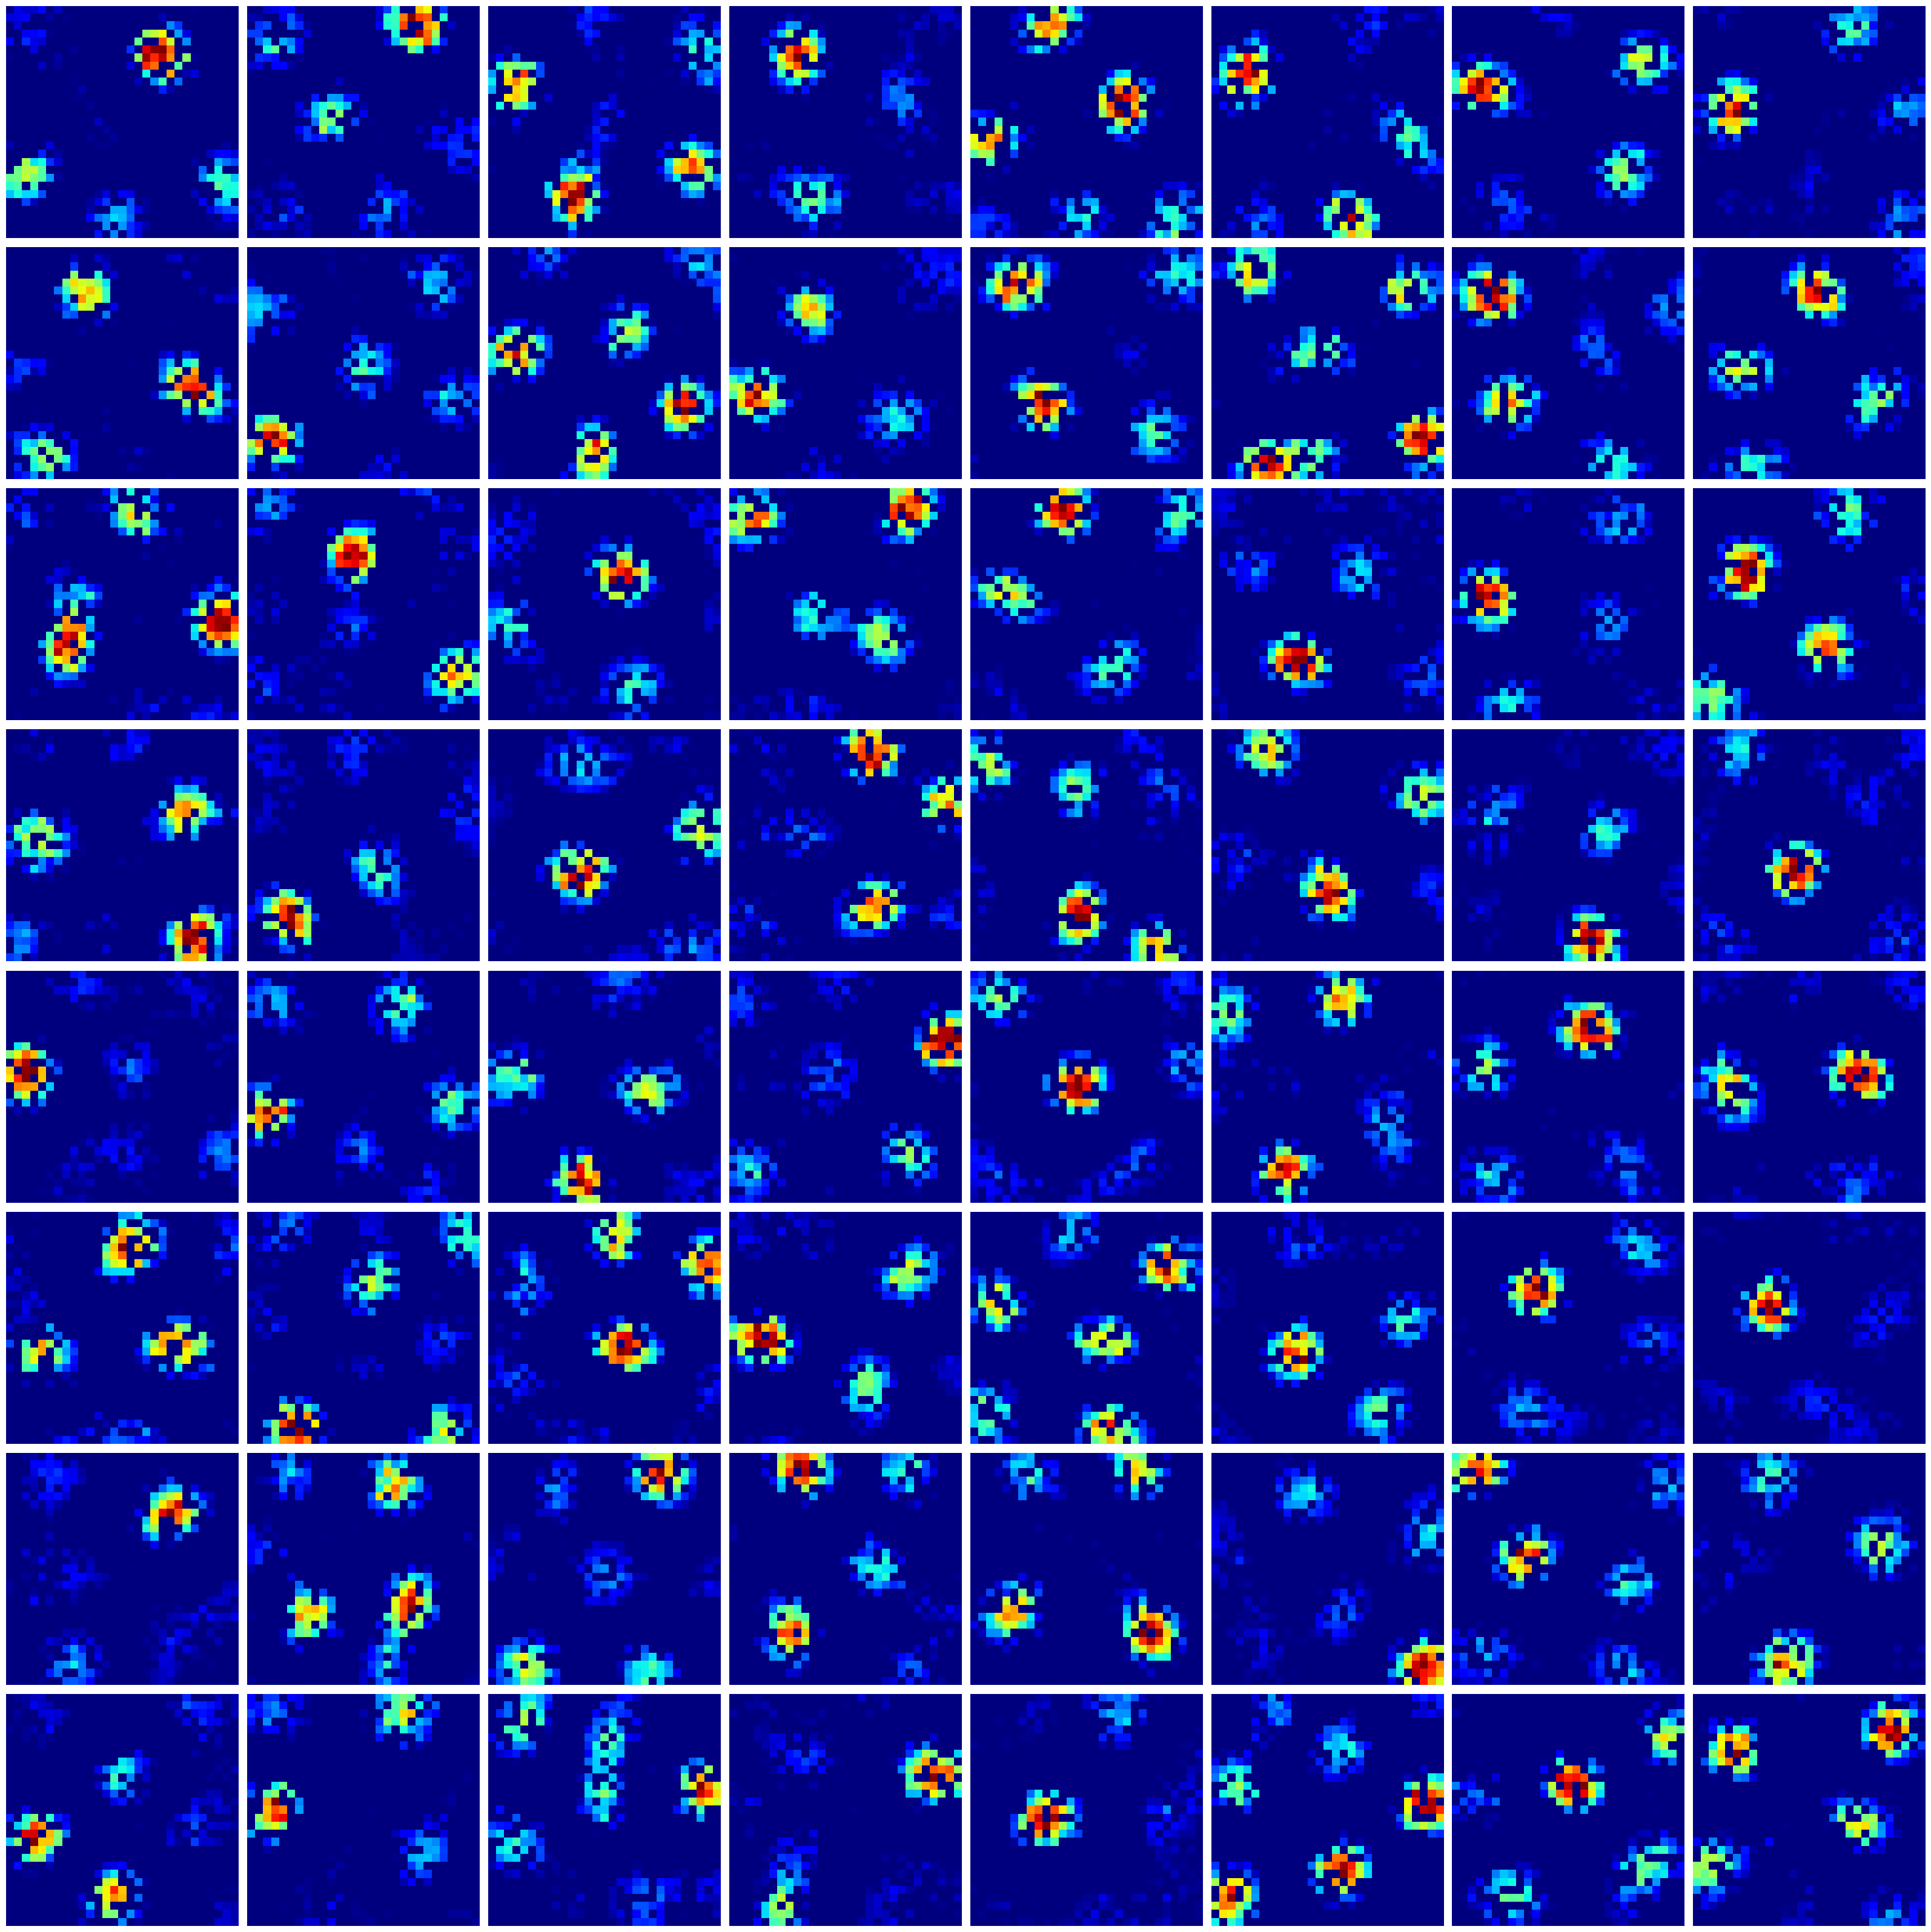

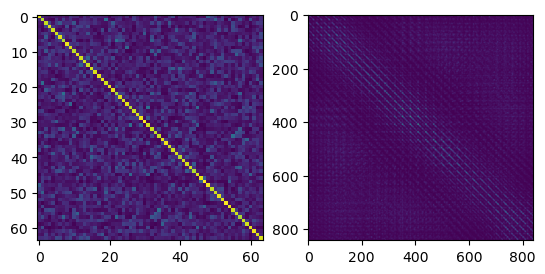

In [111]:
## AutoGrad attempt with pymanopt ##
import torch
#constrain the problem so that G.T@G = I always


def constrained_optimisation(P, n_grid_cells, max_iterations=5000):
    """
    Ultra-compact single function version.
    """
    import pymanopt
    from pymanopt.manifolds import Stiefel
    from pymanopt.optimizers import TrustRegions
    
    P_torch = torch.tensor(P, dtype=torch.float64)
    Sigma_torch = P_torch @ P_torch.T
    Sigma_torch = Sigma_torch/torch.linalg.norm(Sigma_torch)
    manifold = Stiefel(P.shape[0], n_grid_cells)
    
    @pymanopt.function.pytorch(manifold)
    def cost(G):
        G = torch.nn.functional.relu(G)
        return -torch.trace(G.T @ Sigma_torch @ G)
    
    problem = pymanopt.Problem(manifold, cost)
    optimizer = TrustRegions(max_iterations=max_iterations)
    
    G_init, _ = np.linalg.qr(np.random.randn(P.shape[0], n_grid_cells))
    result = optimizer.run(problem, initial_point=G_init)
    
    return result.point, result.point.T @ P  # Return G, W



Ng = 64
n_plot_rows = int(np.sqrt(Ng))

G, _ = constrained_optimisation(positionsXplace_cells, Ng, max_iterations = 100)
G = np.maximum(G,0)
fig, ax = plt.subplots(n_plot_rows,Ng//n_plot_rows, 
                            figsize = (4*Ng//n_plot_rows,4*n_plot_rows))
for i, axis in enumerate(ax.flatten()):
    axis.imshow(G[:,i].reshape(res,res), cmap = 'jet')
    axis.axis('off')
fig.tight_layout()
plt.show()

#plotting covariance
fig, ax = plt.subplots(1,2)
ax[0].imshow(G.T@G) #will be I
ax[1].imshow(G@G.T) #should be periodic over space

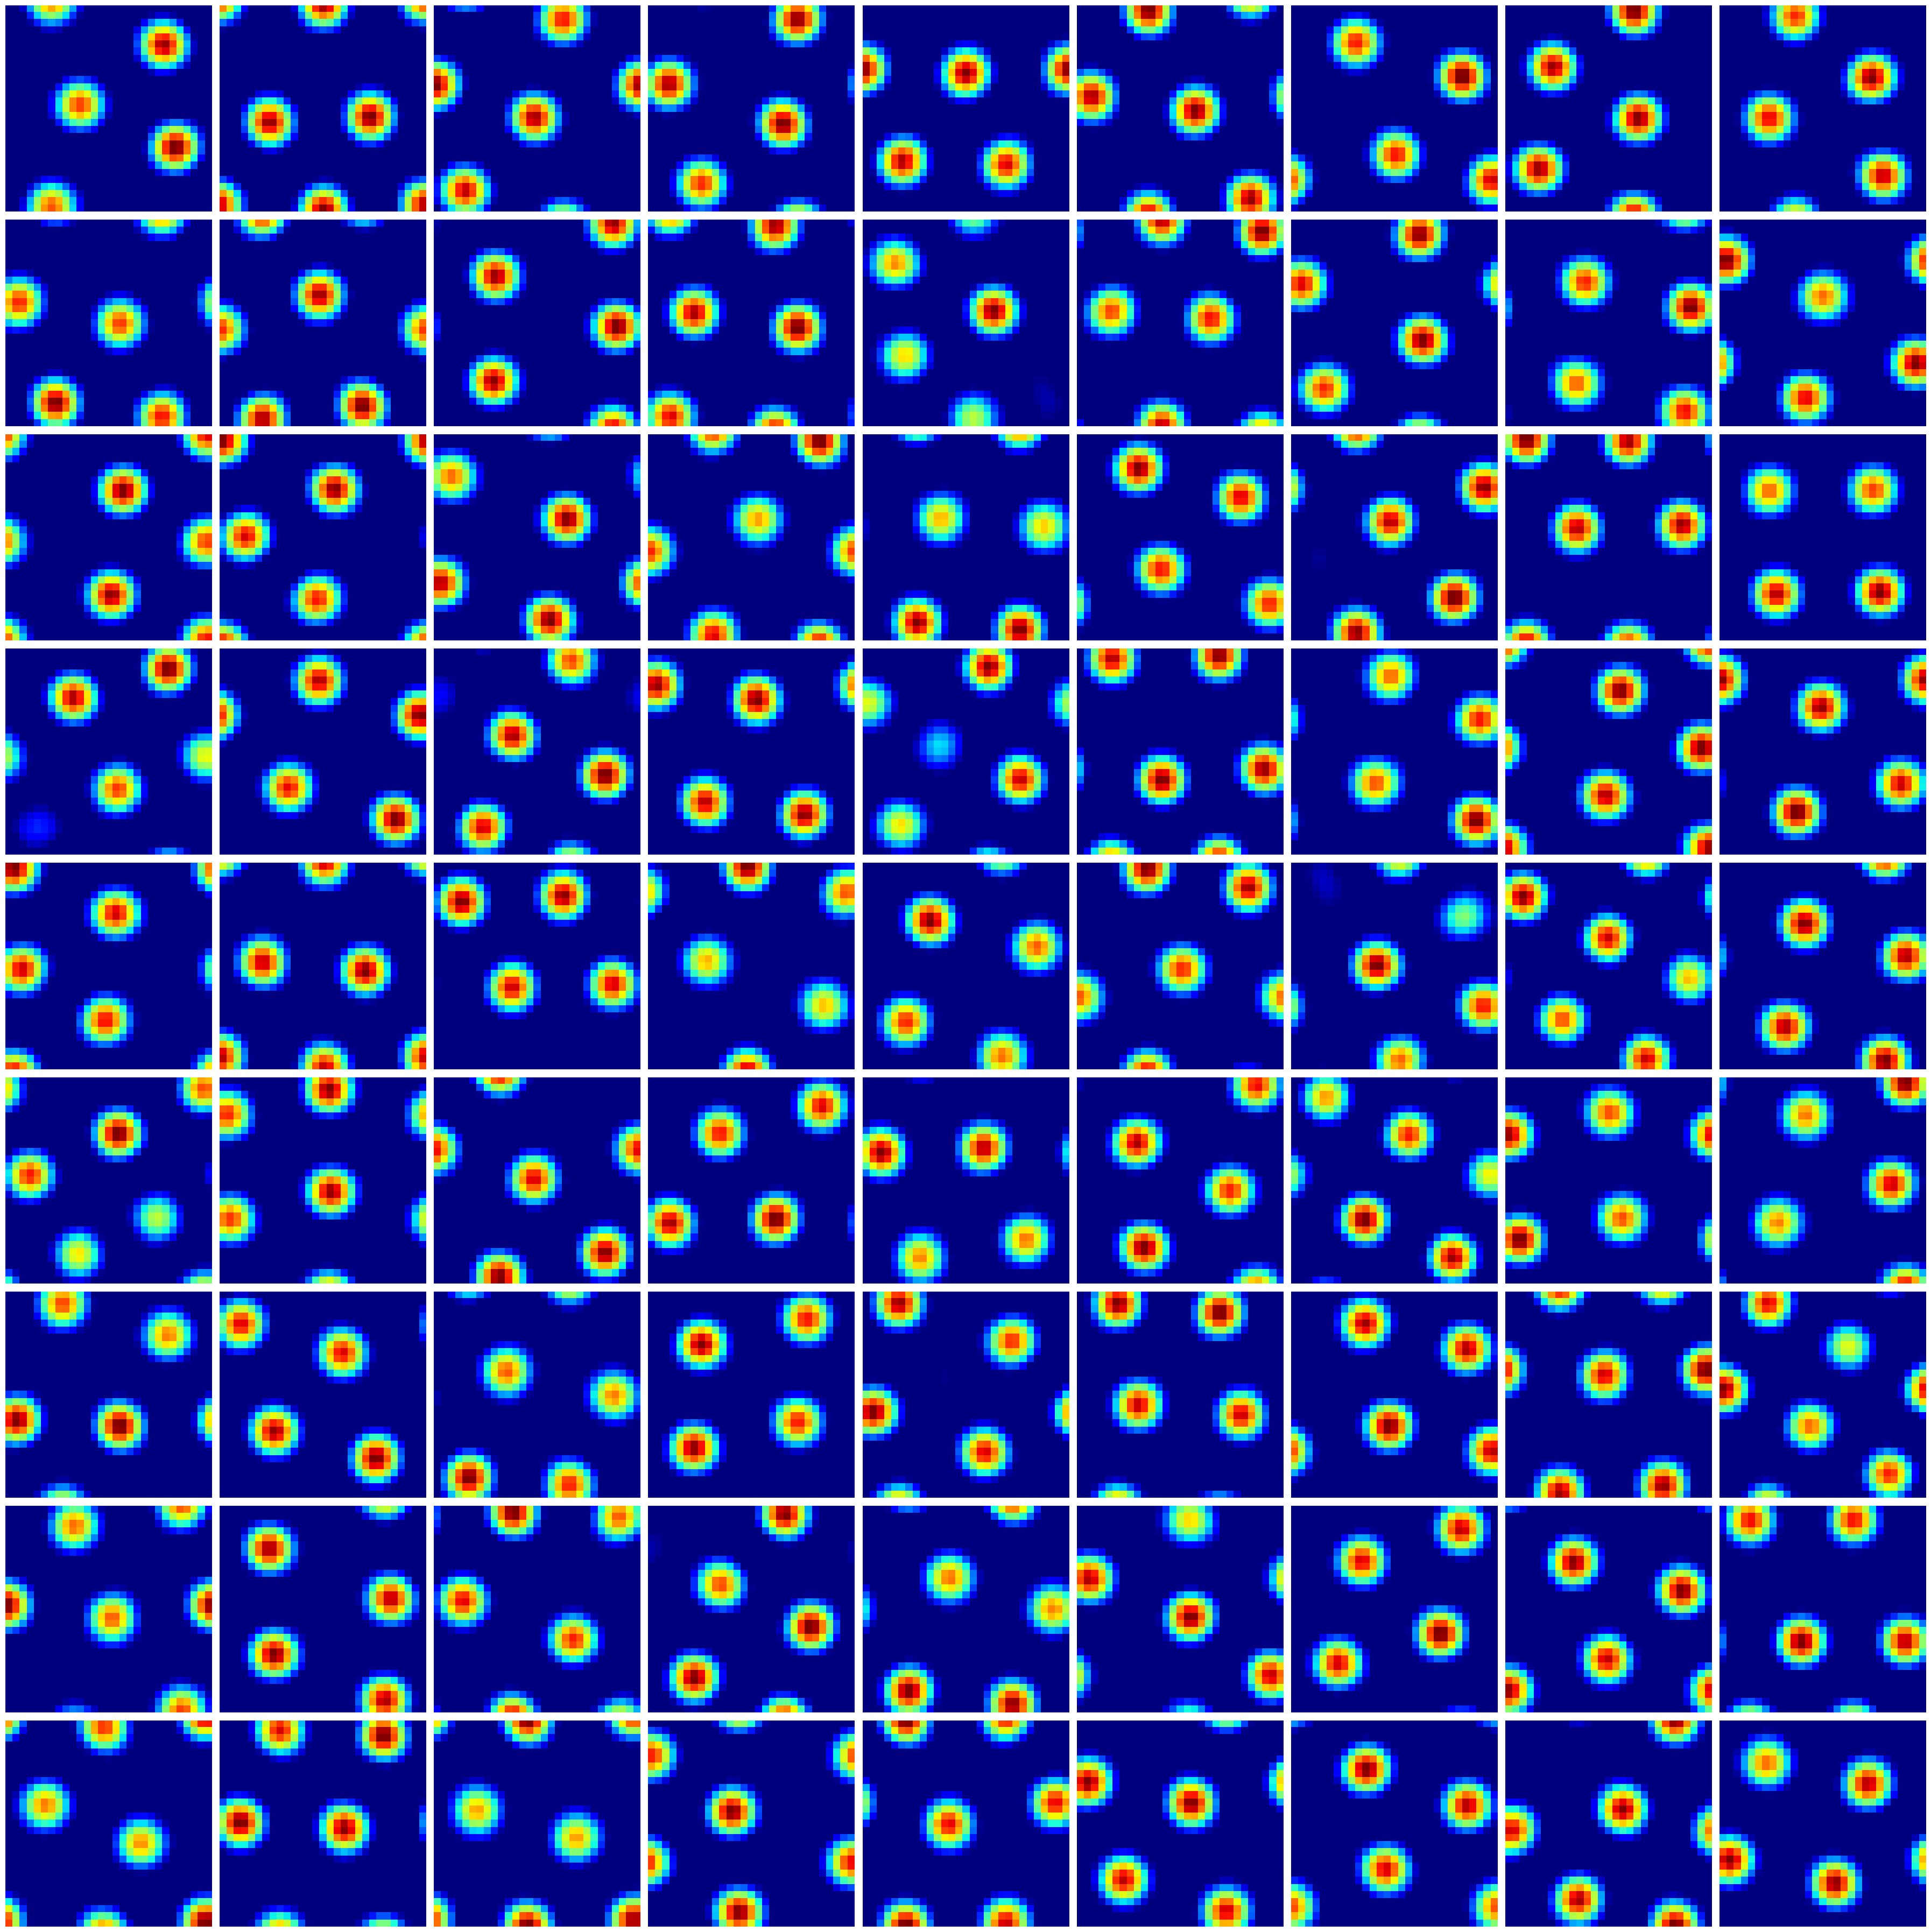

 49%|████▉     | 40/81 [00:00<00:00, 61.97it/s]/nfs/nhome/live/cburns/.conda/envs/GridMaze/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 81/81 [00:01<00:00, 67.72it/s]


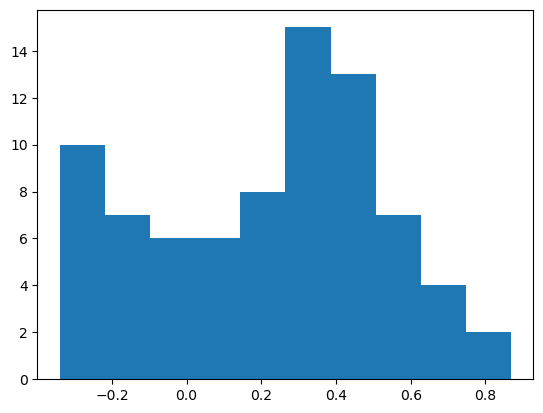

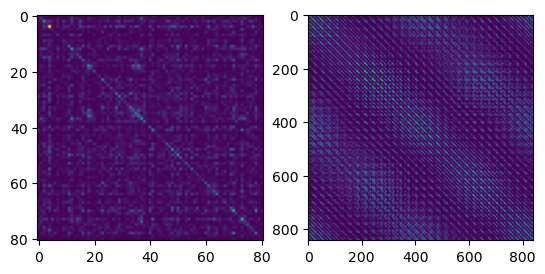

In [260]:
# Fast FFT solver:
# Symmetry-breaking nonlinearity (relu)

def convolve_with_C(g, Ctilde):
    '''
    Convolves the input g with the kernel C
    '''
    gtilde = np.fft.fft2(g, [res, res])
    gconv = np.real(np.fft.ifft2(gtilde*Ctilde))
    gconv = np.roll(np.roll(gconv, res//2+1, axis=1), res//2+1, axis=2)
    
    return gconv

def relu(x):
    return np.maximum(x,0)

Ng = 9**2
n_plot_rows = int(np.sqrt(Ng))
T = 1000
lr = 5e-5

#NOTE THAT THE VARIABILITY IN ORIENTATION / PHASE DEPENDS ON INITIAL RANDOM SEED
G = np.random.randn(Ng,res,res) * 1e-8
#repeated_init = np.random.randn(res,res)*1e-8
#G = np.stack([ repeated_init for _ in range(Ng)])

for i in range(T):
    G +=lr*(-G + convolve_with_C(G, Ctilde))
    G = relu(G)
    if i%100==99:
        fig, ax = plt.subplots(n_plot_rows,Ng//n_plot_rows, 
                               figsize = (4*Ng//n_plot_rows,4*n_plot_rows))
        for i, axis in enumerate(ax.flatten()):
            axis.imshow(G[i], cmap = 'jet')
            axis.axis('off')
        fig.tight_layout()
        plt.show()
        break
    if np.all(np.isnan(G[0])):
        print(f'all NaN at iteration {i}')
        break
            
            
## Grid scoring ## 
from tqdm import tqdm
from GridModels.code.functions import gridcell_metrics as gmetrics
grid_scores = []
sacs = []
for ratemap in tqdm(G):
    coords_range = [[min(binx),max(binx)],[min(biny),max(biny)]]
    sacs.append(spatial.autoCorr2D(np.nan_to_num(ratemap.copy(), 0), np.isnan(ratemap.copy())) )
    mask_parameters = [(0.1,1)] #trying to exclude the centre as in Gardner et al.
    scorer = gmetrics.GridScorer(len(binx)-1, coords_range, mask_parameters)
    grid_scores.append(scorer.get_grid_properties(ratemap)['gridscore_60'])

plt.hist(grid_scores)
plt.show()

#plotting covariance 

fig, ax = plt.subplots(1,2)
reshaped_G = G.reshape(Ng,res*res) #(Ng,Nx)
ax[0].imshow(reshaped_G@reshaped_G.T) #should be I
ax[1].imshow(reshaped_G.T@reshaped_G) #should span coordinate space with periodicity

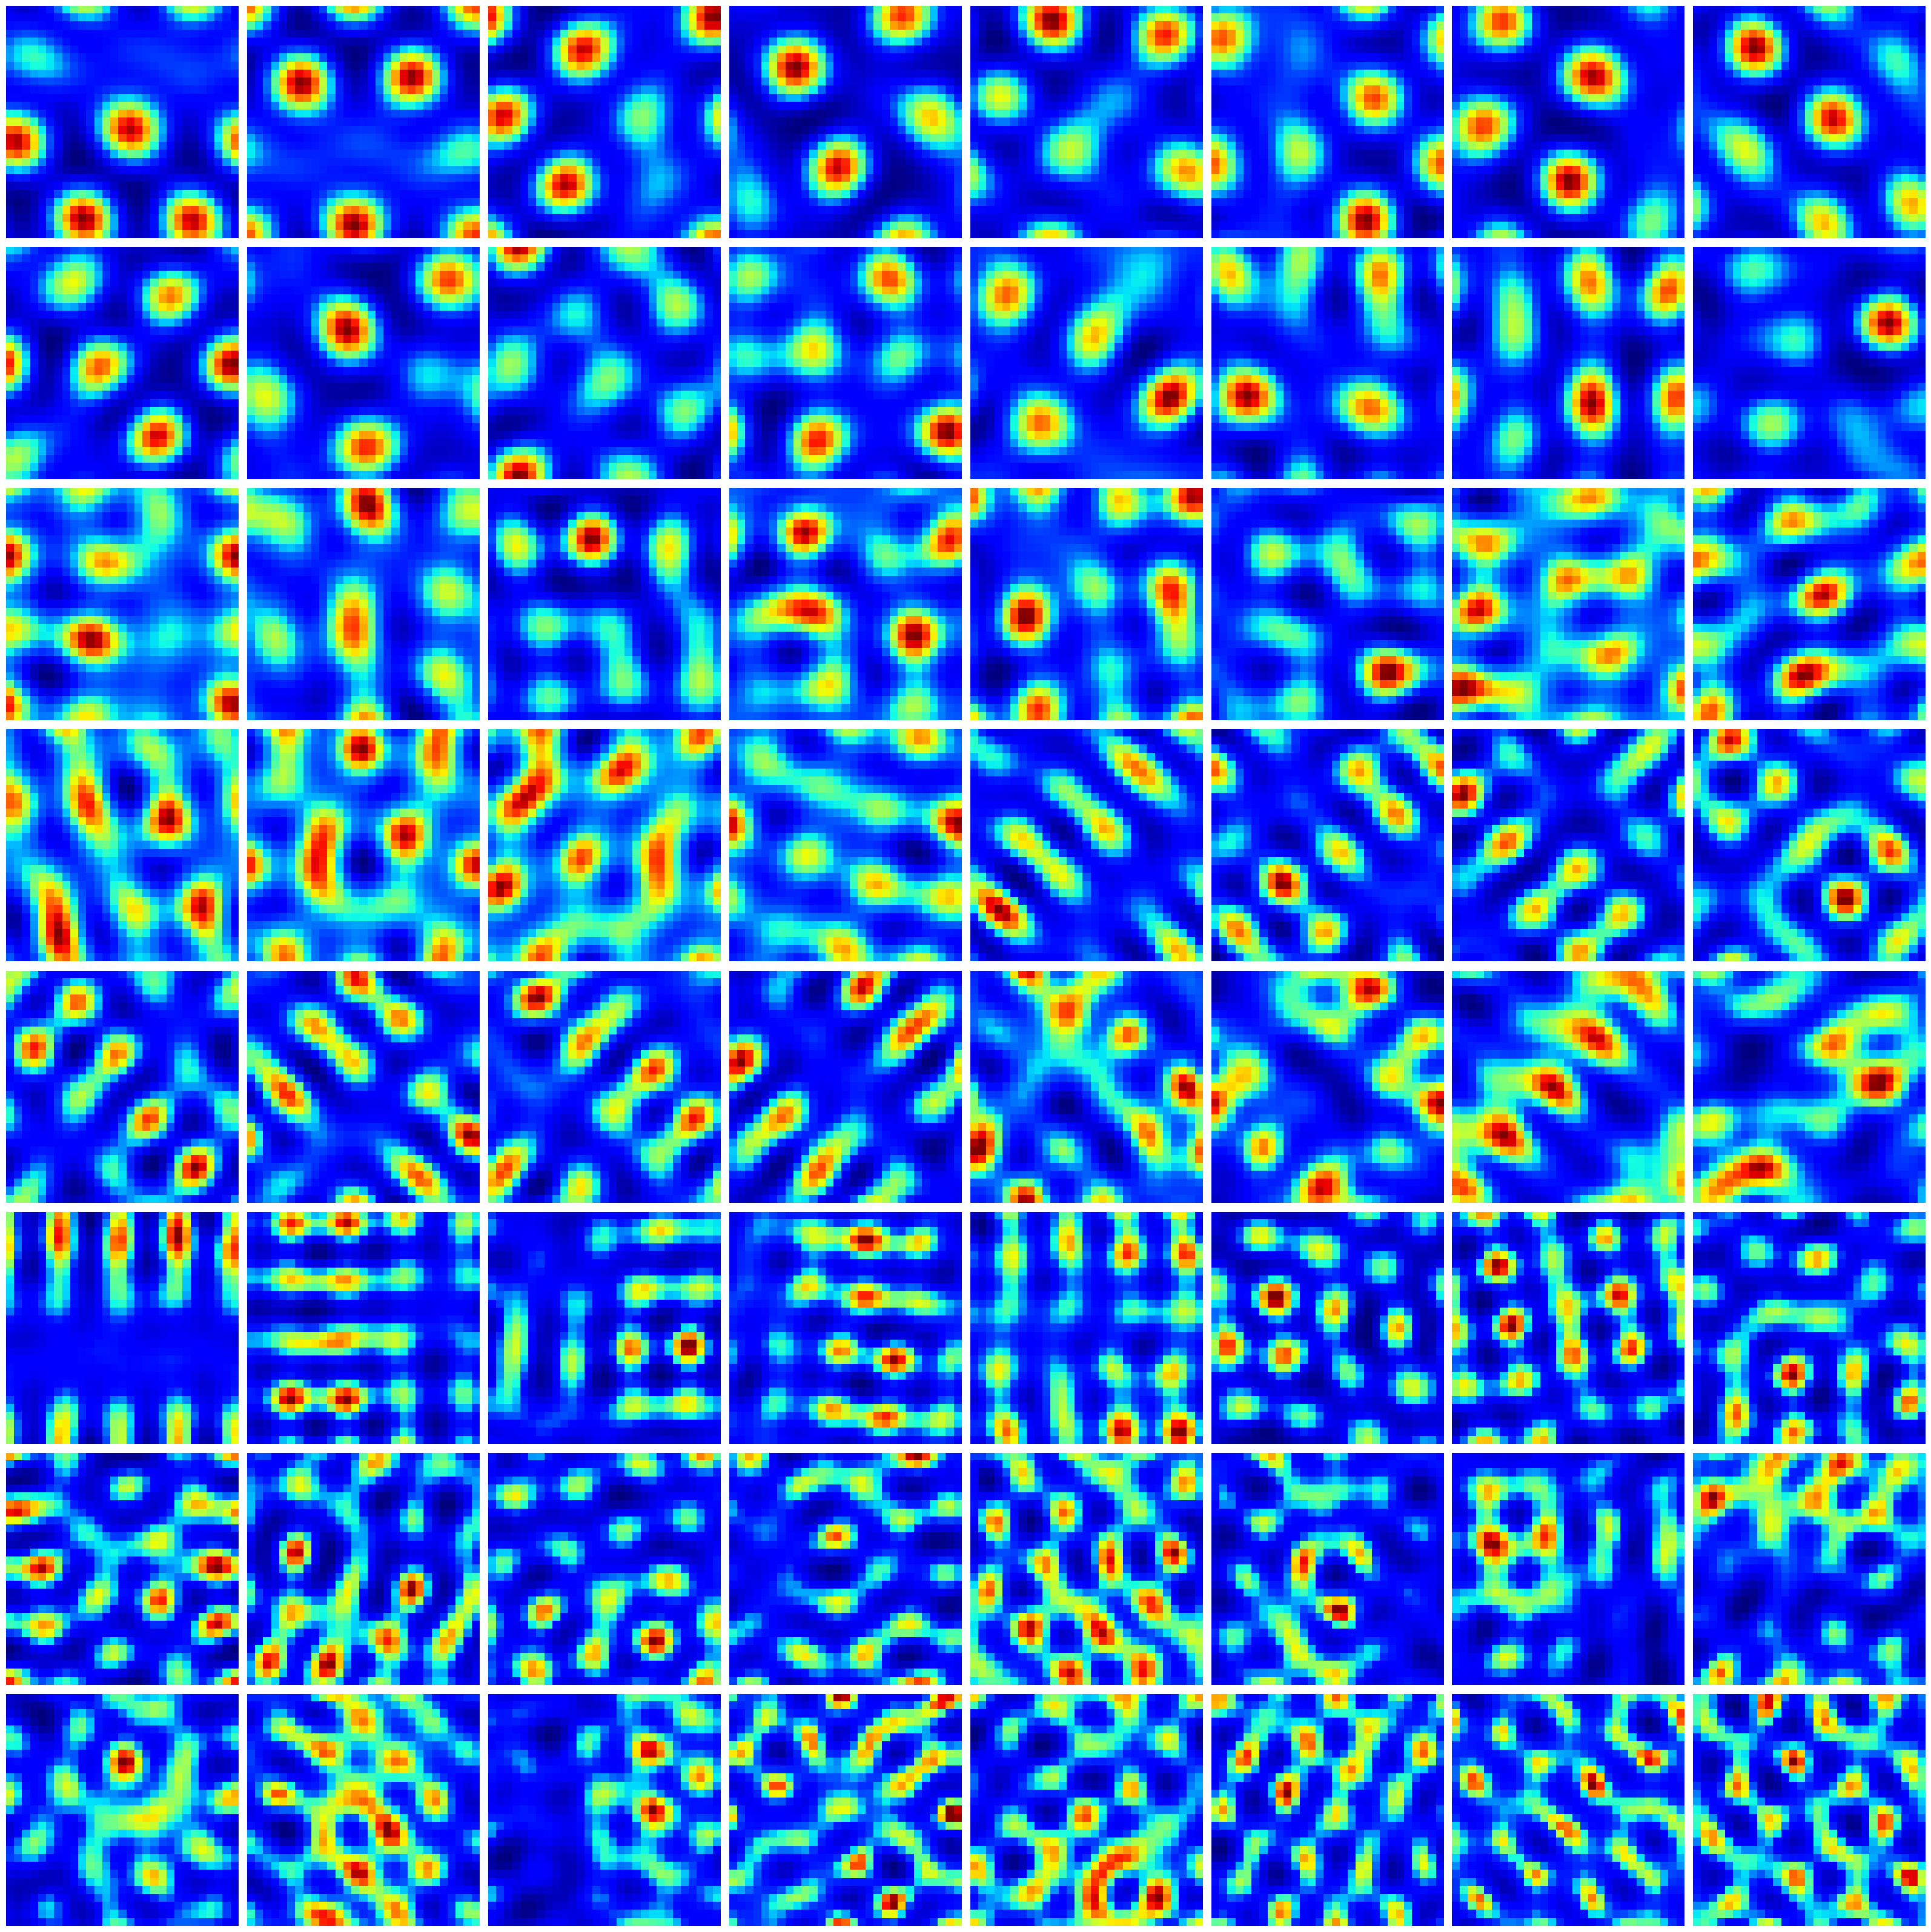

100%|██████████| 64/64 [00:01<00:00, 62.17it/s]


(array([10., 23., 15.,  6.,  6.,  1.,  1.,  0.,  0.,  2.]),
 array([-0.32431963, -0.21516903, -0.10601843,  0.00313217,  0.11228277,
         0.22143336,  0.33058396,  0.43973456,  0.54888516,  0.65803576,
         0.76718636]),
 <BarContainer object of 10 artists>)

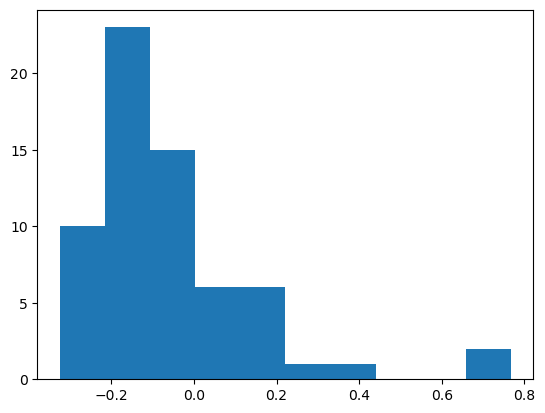

In [ ]:
## FFT and orthogonalised (multi-grid) ##
def phi(x,r):
    return np.maximum(r*x,0)

Ng = 8**2
n_plot_rows = int(np.sqrt(Ng))
r = 30
T = 5000
lr = 1.3e-6
G = np.random.randn(Ng,res,res) * 1e-8
#repeated_init = np.random.randn(res,res)*1e-8
#G = np.stack([ repeated_init for _ in range(Ng)])

for i in range(T):
    H = convolve_with_C(G, Ctilde)
    #H = phi(H,r) #this is not in the original code, but could be helpful to integrate non-negativity in the orthogonalisation penalty?
    Hr = H.reshape([Ng, -1])
    Gr = G.reshape([Ng, -1])
    oja = Gr.T.dot(np.tril(Gr.dot(Hr.T))).T.reshape([Ng,res,res])
    G_relu = phi(G,r)
    #we should balance constraints
    balance_scalar = np.abs(H-oja).max()/np.abs(G_relu).max() # 1 #np.min([H.max(),oja.max()])/G_relu.max() #(np.abs(H-oja).max()/np.abs(G_relu).max())
    G += lr * (H - oja + balance_scalar*G_relu) 
    
    if i%200==199:
        fig, ax = plt.subplots(n_plot_rows,Ng//n_plot_rows, 
                               figsize = (4*Ng//n_plot_rows,4*n_plot_rows))
        for i, axis in enumerate(ax.flatten()):
            axis.imshow(np.flip(G)[i], cmap = 'jet')
            axis.axis('off')
        fig.tight_layout()
        plt.show()
        break
    if np.all(np.isnan(G[0])):
        print(f'all NaN at iteration {i}')
        break
    
    
## Grid scoring ## 
from tqdm import tqdm
from GridModels.code.functions import gridcell_metrics as gmetrics
grid_scores = []
sacs = []
for ratemap in tqdm(G):
    coords_range = [[min(binx),max(binx)],[min(biny),max(biny)]]
    sacs.append(spatial.autoCorr2D(np.nan_to_num(ratemap.copy(), 0), np.isnan(ratemap.copy())) )
    mask_parameters = [(0.1,1)] #trying to exclude the centre as in Gardner et al.
    scorer = gmetrics.GridScorer(len(binx)-1, coords_range, mask_parameters)
    grid_scores.append(scorer.get_grid_properties(ratemap)['gridscore_60'])

plt.hist(grid_scores)
plt.show()

# inspecting covariance across grid cells and across positions #
fig, ax = plt.subplots(1,2)
reshaped_G = G.reshape(Ng,res*res) #(Ng,Nx)
ax[0].imshow(reshaped_G@reshaped_G.T) #should be I
ax[1].imshow(reshaped_G.T@reshaped_G) #should span coordinate space with periodicity


## Grid parameter estimation

Here we try to estimate scale, orientation, and phase of each cell (relative to idealised perfect hexagonal representation).

Using device: cuda


/ceph/behrens/peter_doohan/goalNav_mEC/experiment/code/GridModels/code/functions/hexagonal_gridcells.py:190: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  offsets = torch.tensor(offsets).to(dtype=torch.float32, device = device)


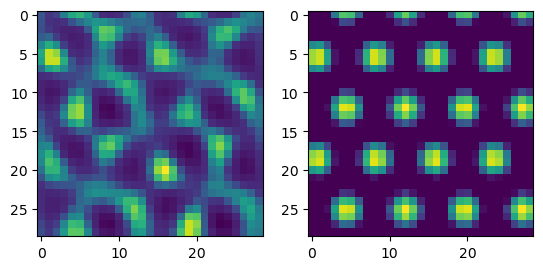

In [ ]:
from GridModels.code.functions import hexagonal_gridcells as hex
from GridMaze.analysis.metrics import get_grid_params as gparams
#normalised
G = G/G.max(axis=(1,2)).reshape(G.shape[0],1,1)
test_ratemap = G[0]
b2m = v2p.options.environment_scale/test_ratemap.shape[0]
fit_dict = gparams.fit_hexagonal_model2ratemap(test_ratemap, bins2metres = b2m )
best_ratemap = fit_dict['fitted_ratemap']

fig, ax = plt.subplots(1,2)
ax[0].imshow(test_ratemap)
ax[1].imshow(best_ratemap)

In [ ]:
params_dict = fit_dict
 #The transformation we do here is a linear map via basis vectors.
    #these vectors correspond
l1 = l2 = params_dict['scale'] #size of basis_1 = basis_2
theta= np.pi/3 #angle between vectors fixed for hexagonal model.
phi=np.rad2deg(params_dict['orientation']) #global orientation of grid pattern
#construct the basis vectors with some linear algebra
basis_1 = np.array([[l1*np.cos(phi)],
                    [-l1*np.sin(phi)]])
basis_2 = np.array([[l2*np.cos(theta-phi)],
                    [l2*np.sin(theta-phi)]])

#Now one lengthscale in the new basis coordinates 
# we simply want to project the orientations onto the torus


# Project points onto the torus
## we're getting closer thanks to https://math.stackexchange.com/questions/851136/are-there-2d-analogues-for-integer-division-and-modular-arithmetic
scales = np.array([np.linalg.norm(basis_1), np.linalg.norm(basis_2)])
centered_positions = np.array([0,0])# params_dict['offset']
shifted_positions = centered_positions + np.array([basis_1.max()/2,basis_2.max()/2]) #+ np.transpose(basis_1+basis_2)/2 #np.array([(20,0), (40,0), (10,17)])
shifted_positions = np.transpose(shifted_positions) # (2,n_pos)
basis_matrix = np.stack([basis_1,basis_2],axis=1).squeeze()
x = np.matmul(np.linalg.inv(basis_matrix),shifted_positions)
basis_multiples = np.floor(x)#+[np.linalg.norm(basis_1)/2,np.linalg.norm(basis_2)/2]
remainder = shifted_positions - (np.matmul(basis_matrix,basis_multiples))
# Now perform modulus operations, wrapping remainder coordinates back to each other
toroidal_coords = remainder.copy()
#toroidal_coords = np.matmul(np.linalg.inv(basis_matrix),toroidal_coords)
#toroidal_coords = toroidal_coords - np.array([[basis_1.max()/2],[basis_2.max()/2]])
toroidal_coords[0] = (remainder[0] % basis_1.max())/basis_1.max()*2*np.pi
toroidal_coords[1] = (remainder[1] % basis_2.max())//basis_2.max()*2*np.pi

print(toroidal_coords)

[1.59134249 0.        ]


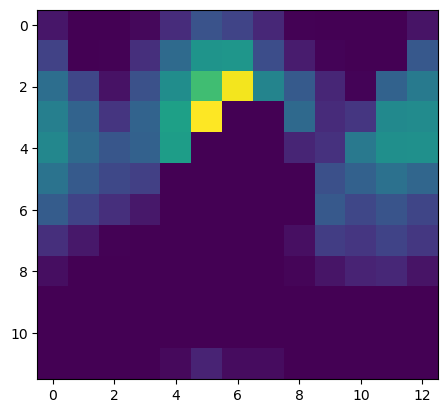

In [ ]:
# prompt: Smooth r from above by taking binned averages weighted by distance to centre in the original ratemap and with values equal to firingrate[1]

import numpy as np
import matplotlib.pyplot as plt

def toroidal_ratemap(firingrate, pos, basis_1, basis_2):
    """
    Smooths a ratemap by taking binned averages weighted by distance to the center.

    Args:
        firingrate: The firing rate at each position.
        pos: The positions corresponding to the firing rates.
        basis_1: First basis vector.
        basis_2: Second basis vector.
        n_bins: The number of bins to use for smoothing.

    Returns:
        A smoothed ratemap.
    """

    # Project points onto the torus
    periods = np.array([basis_1.max(), basis_2.max()]) #np.array([np.linalg.norm(basis_1), np.linalg.norm(basis_2)])
    centered_pos = pos - [pos[:,0].max()/2, pos[:,1].max()/2]
    n = centered_pos + periods / 2 #shifted position
    Q = np.stack([basis_1, basis_2], axis=0).squeeze()
    x = np.matmul(n, np.linalg.inv(Q))
    d = np.floor(x)
    r = n - np.matmul(d, Q)
    r[:, 0] = r[:, 0] % periods[0]
    r[:, 1] = r[:, 1] % periods[1]

    #scale_matrix = np.array([[1/basis_1.max(),0],[0,1/basis_2.max()]])
    #r = np.transpose(np.matmul(scale_matrix, np.transpose(r)))
    x_min, x_max = np.min(r[:, 0]), np.max(r[:, 0])
    y_min, y_max = np.min(r[:, 1]), np.max(r[:, 1])
    # Calculate the number of bins based on the data range and the desired bin size
    nxbins = int(x_max - x_min)
    nybins = int(y_max - y_min)
    #weight by distance to centre in original autocorrelogram
    distances = np.linalg.norm(centered_pos,axis=1)
    distances = distances/np.max(distances)+1
    dist_weight = 1/distances
    # Create a 2D histogram of the number of spikes (weighted histogram)
    ratemap, binx, biny = np.histogram2d(
        r[:,0], r[:,1], bins=[nxbins, nybins], weights=firingrate*dist_weight, #
        range=[[x_min, x_max], [y_min, y_max]]
    )

    occupancy, _, _ = np.histogram2d(r[:,0], r[:,1], bins=[nxbins, nybins], range=[[x_min, x_max], [y_min, y_max]])

    # Compute the firing rate (spikes per second) for each bin
    # Avoid division by zero by only dividing where occupancy > 0
    h = np.zeros_like(ratemap)
    valid_bins = occupancy > 0
    h[valid_bins] = ratemap[valid_bins] / occupancy[valid_bins]

    return h.T


def params2basis_vectors(params):
    '''Returns basis vectors from a parameters dictionary with 1, l2, theta, and phi'''
    #hard-coded trigonometry
    l1 = params['l1']
    l2=params['l2']
    theta=params['theta']
    phi=params['phi']
    basis_1 = np.array([[l1*np.cos(phi)],
                       [-l1*np.sin(phi)]])
    basis_2 = np.array([[l2*np.cos(theta-phi)],
                       [l2*np.sin(theta-phi)]])
    return basis_1, basis_2


basis_1,basis_2 = params2basis_vectors({'l1':params_dict['scale']/b2m,
                                        'l2':params_dict['scale']/b2m,
                                        'theta':np.pi/3,
                                        'phi':params_dict['orientation']})


def get_flattened_coords(N):
    """Generates flattened coordinates for a square meshgrid."""
    x = np.arange(N)
    y = np.arange(N)
    xv, yv = np.meshgrid(x, y)
    return np.stack((xv.flatten(), yv.flatten()), axis=1)
grid_positions = get_flattened_coords(test_ratemap.shape[0])

reshaped_ratemap = test_ratemap.reshape(test_ratemap.shape[0]*test_ratemap.shape[1])
gt_ratemap, params = hex.get_fast_hexagonal_rates(grid_positions, 
                                          [params_dict['scale']/b2m],
                                          [np.rad2deg(params_dict['orientation'])],
                                          offsets = [params_dict['offset']/b2m])
gt_ratemap = gt_ratemap.squeeze().cpu().numpy()

plt.imshow(toroidal_ratemap(gt_ratemap,
                            grid_positions,
                            basis_1,
                            basis_2))




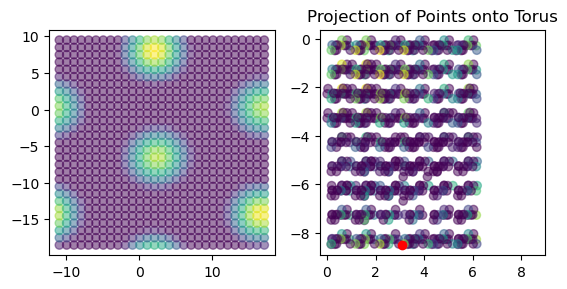

In [ ]:
# Example usage:
# Sample points

N = test_ratemap.shape[0]

points = np.random.rand(N**2, 2) * 100  # Example: 100 random points in a 10x10 square

# Define basis vectors (replace with your actual vectors)

basis_1,basis_2 = params2basis_vectors({'l1':params_dict['scale']/b2m,
                                        'l2':params_dict['scale']/b2m,
                                        'theta':np.pi/3,
                                        'phi':np.rad2deg(params_dict['orientation'])})


# Project points onto the torus
## we're getting closer thanks to https://math.stackexchange.com/questions/851136/are-there-2d-analogues-for-integer-division-and-modular-arithmetic
scales = np.array([np.linalg.norm(basis_1), np.linalg.norm(basis_2)])
centered_positions =  grid_positions -[grid_positions[:,0].max()/2,grid_positions[:,1].max()/2]
shifted_positions = centered_positions + np.array([basis_1.max()/2,basis_2.max()/2]) #+ np.transpose(basis_1+basis_2)/2 #np.array([(20,0), (40,0), (10,17)])
shifted_positions = np.transpose(shifted_positions) # (2,n_pos)
basis_matrix = np.stack([basis_1,basis_2],axis=1).squeeze()
x = np.matmul(np.linalg.inv(basis_matrix),shifted_positions)
basis_multiples = np.floor(x)#+[np.linalg.norm(basis_1)/2,np.linalg.norm(basis_2)/2]
remainder = shifted_positions - (np.matmul(basis_matrix,basis_multiples))
# Now perform modulus operations, wrapping remainder coordinates back to each other
toroidal_coords = remainder.copy()
#toroidal_coords = np.matmul(np.linalg.inv(basis_matrix),toroidal_coords)
#toroidal_coords = toroidal_coords - np.array([[basis_1.max()/2],[basis_2.max()/2]])
toroidal_coords[0,:] = remainder[0,:] % basis_1.max()
toroidal_coords[1,:] = remainder[1,:] % basis_2.max()

## mean per bin

#scale_matrix = np.array([[1/basis_1.max(),0],[0,1/basis_2.max()]])
#toroidal_coords = np.matmul(scale_matrix, toroidal_coords)


toroidal_offset =  toroidal_coords.min(axis=1) + toroidal_coords.max(axis=1)/2 ##((basis_1+basis_2)/2).squeeze()

# Plot the results
fig, ax = plt.subplots(1,2)
ax[0].scatter(shifted_positions[0,:], shifted_positions[1,:], c=reshaped_ratemap, label='Original Points', alpha=0.5)
ax[1].scatter(toroidal_coords[0,:],toroidal_coords[1,:], c=reshaped_ratemap, alpha=0.5)
ax[1].scatter(toroidal_offset[0],toroidal_offset[1], color='red')
ax[0].axis('square')
ax[1].axis('square')
ax[1].set_title("Projection of Points onto Torus")
#ax[1].grid(True)
plt.show()

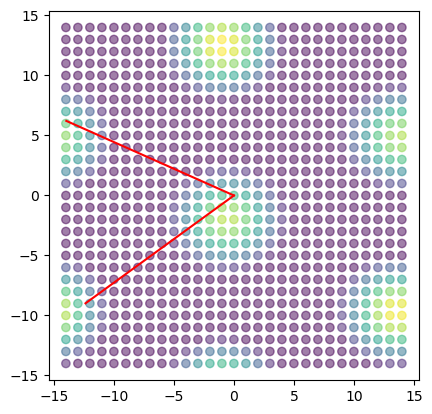

In [ ]:
#checking basis vectors
fig, ax = plt.subplots()
ax.scatter(centered_positions[:,0], 
           centered_positions[:,1], 
           c=reshaped_ratemap, 
           label='Original Points', 
           alpha=0.5)
ax.plot(np.array([0,basis_2[0,0]]),np.array([0,basis_2[1,0]]), color = 'red')
ax.plot(np.array([0,basis_1[0,0]]),np.array([0,basis_1[1,0]]), color = 'red')

ax.axis('square')
plt.show()

## SR representations



### Basic SR from a 2D grid-world (but fine-scale)

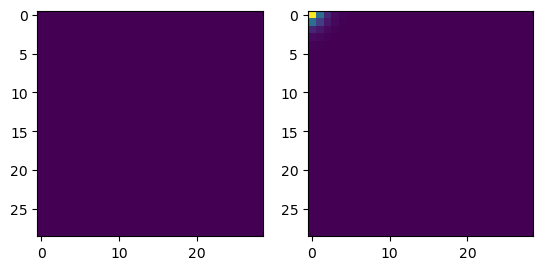

In [6]:
from GridModels.code.functions import SR_maze as sr
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
reload(sr)
res = 29 #ratemap size
example_ratemap = np.ones((res,res))
bin_mask = ~np.isnan(example_ratemap)
sr_matrix, graph = sr.get_SR_from_bin_mask(bin_mask, 
                        discount_factor = 0.75)

fig, ax = plt.subplots(1,2)
ax[0].imshow(example_ratemap)
ax[1].imshow(sr_matrix[0].reshape(res,res))

0.0 % of bins unoccupied


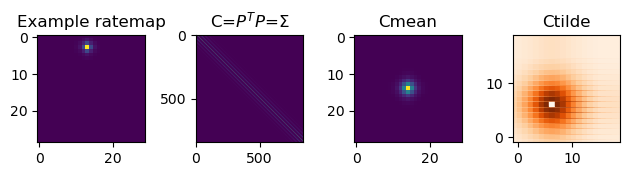

In [8]:
sr_ratemaps = np.stack([sr_matrix[i].reshape(res,res) for i in range(res*res)])

print(f'{round(np.mean(np.isnan(sr_ratemaps))*100,4)} % of bins unoccupied')
sr_ratemaps[np.isnan(sr_ratemaps)] = 1e-6 # set NaN to very small value. Seems to work? But probably wont for maze data
P = sr_ratemaps.reshape(sr_ratemaps.shape[0],sr_ratemaps.shape[1]*sr_ratemaps.shape[2])
## Before any of the C stuff, we need to rescale the ratemaps ##
n_ratemaps = sr_ratemaps.shape[0]
shifted_rm = (sr_ratemaps + np.abs(sr_ratemaps.min(axis = (1,2))).reshape(n_ratemaps,1,1))
sr_ratemaps = shifted_rm/shifted_rm.max(axis = (1,2)).reshape(n_ratemaps,1,1)
# ratemaps should have values between [0,1], so they should be shifted #
res = sr_ratemaps.shape[1]
C = P.T@P
Csquare = C.reshape(res,res,res,res)
Cmean = np.zeros([res,res])
n_additions = 0
for i in range(res):
    for j in range(res):
        Cmean += np.roll(np.roll(Csquare[i,j], -i, axis=0), -j, axis=1)
        n_additions +=1
Cmean = np.roll(np.roll(Cmean, res//2, axis=0), res//2, axis=1)/n_additions #fold the corners onto the center
# Fourier transform
Ctilde = np.fft.fft2(Cmean)
Ctilde[0,0] = 0

## plotting ##
fig, ax = plt.subplots(1,4)
ax[0].set(title = 'Example ratemap')
ax[0].imshow(sr_ratemaps[100])

ax[1].set(title = r'C=$P^TP$=$\Sigma$')
ax[1].imshow(C)

ax[2].set(title ='Cmean')
ax[2].imshow(Cmean)

ax[3].set(title = 'Ctilde')
width = 10
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
ax[3].scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs], s=600, cmap='Oranges', marker='s')
ax[3].axis('square')
fig.tight_layout()

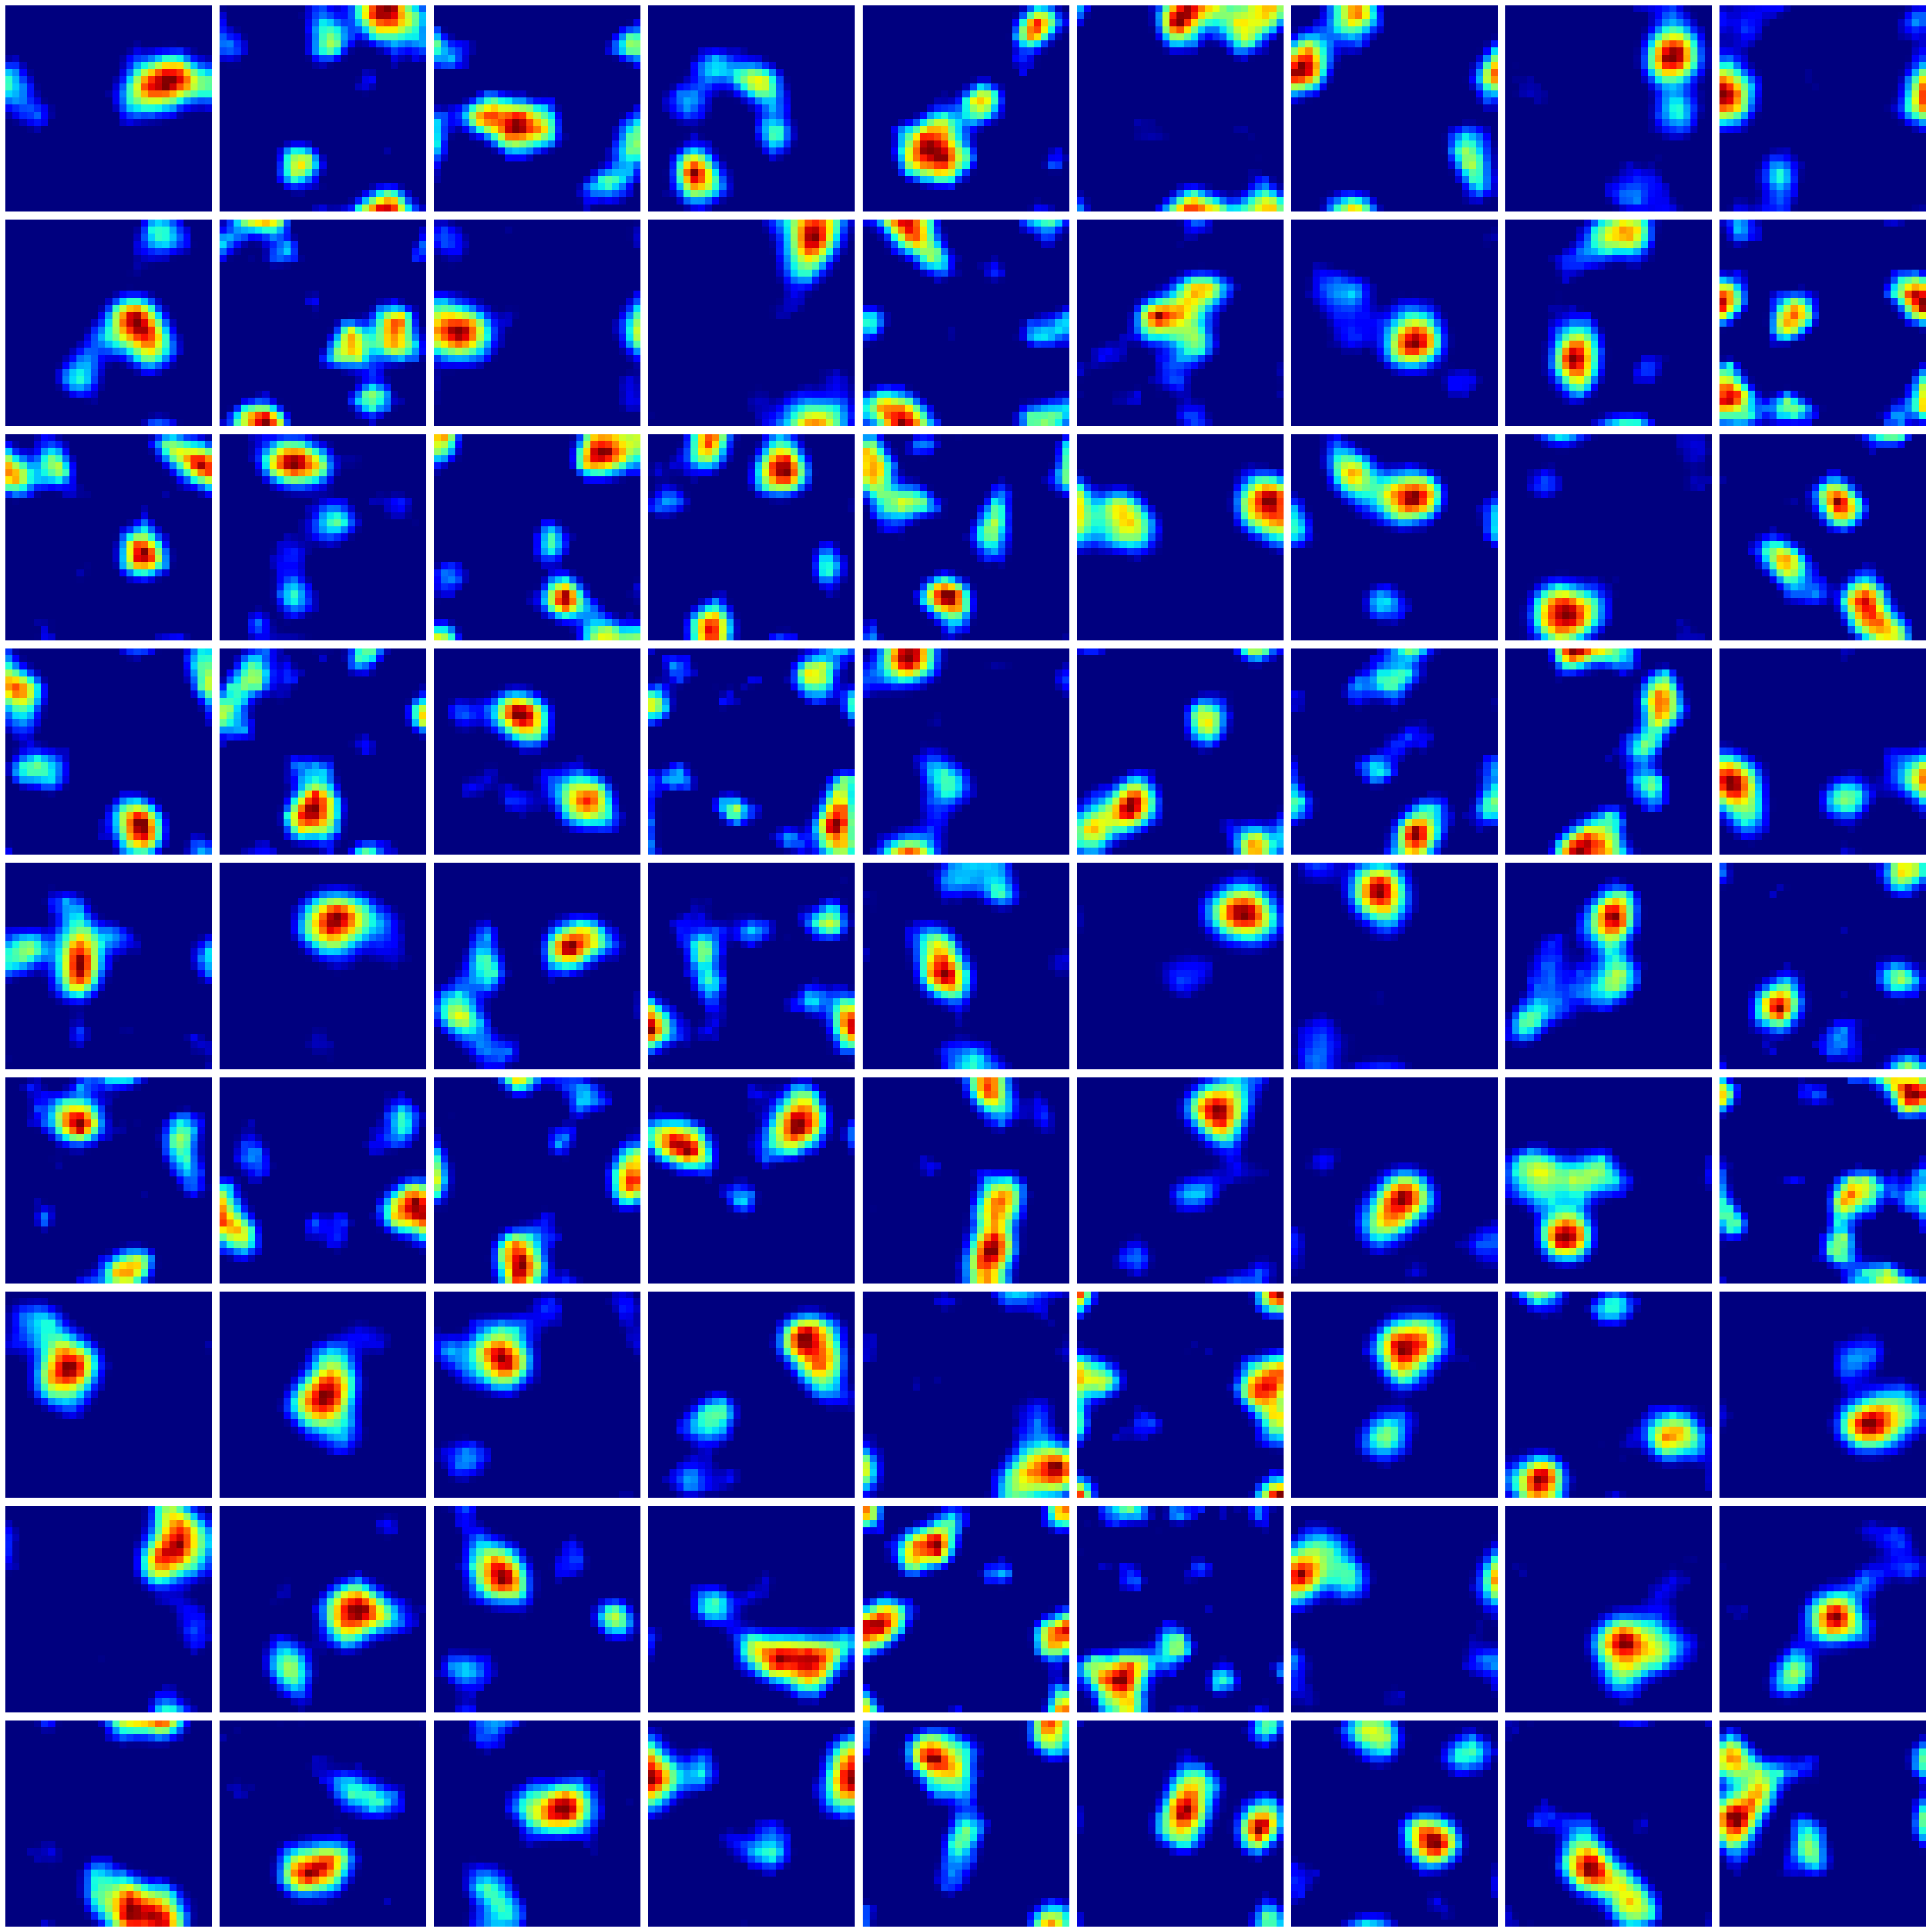

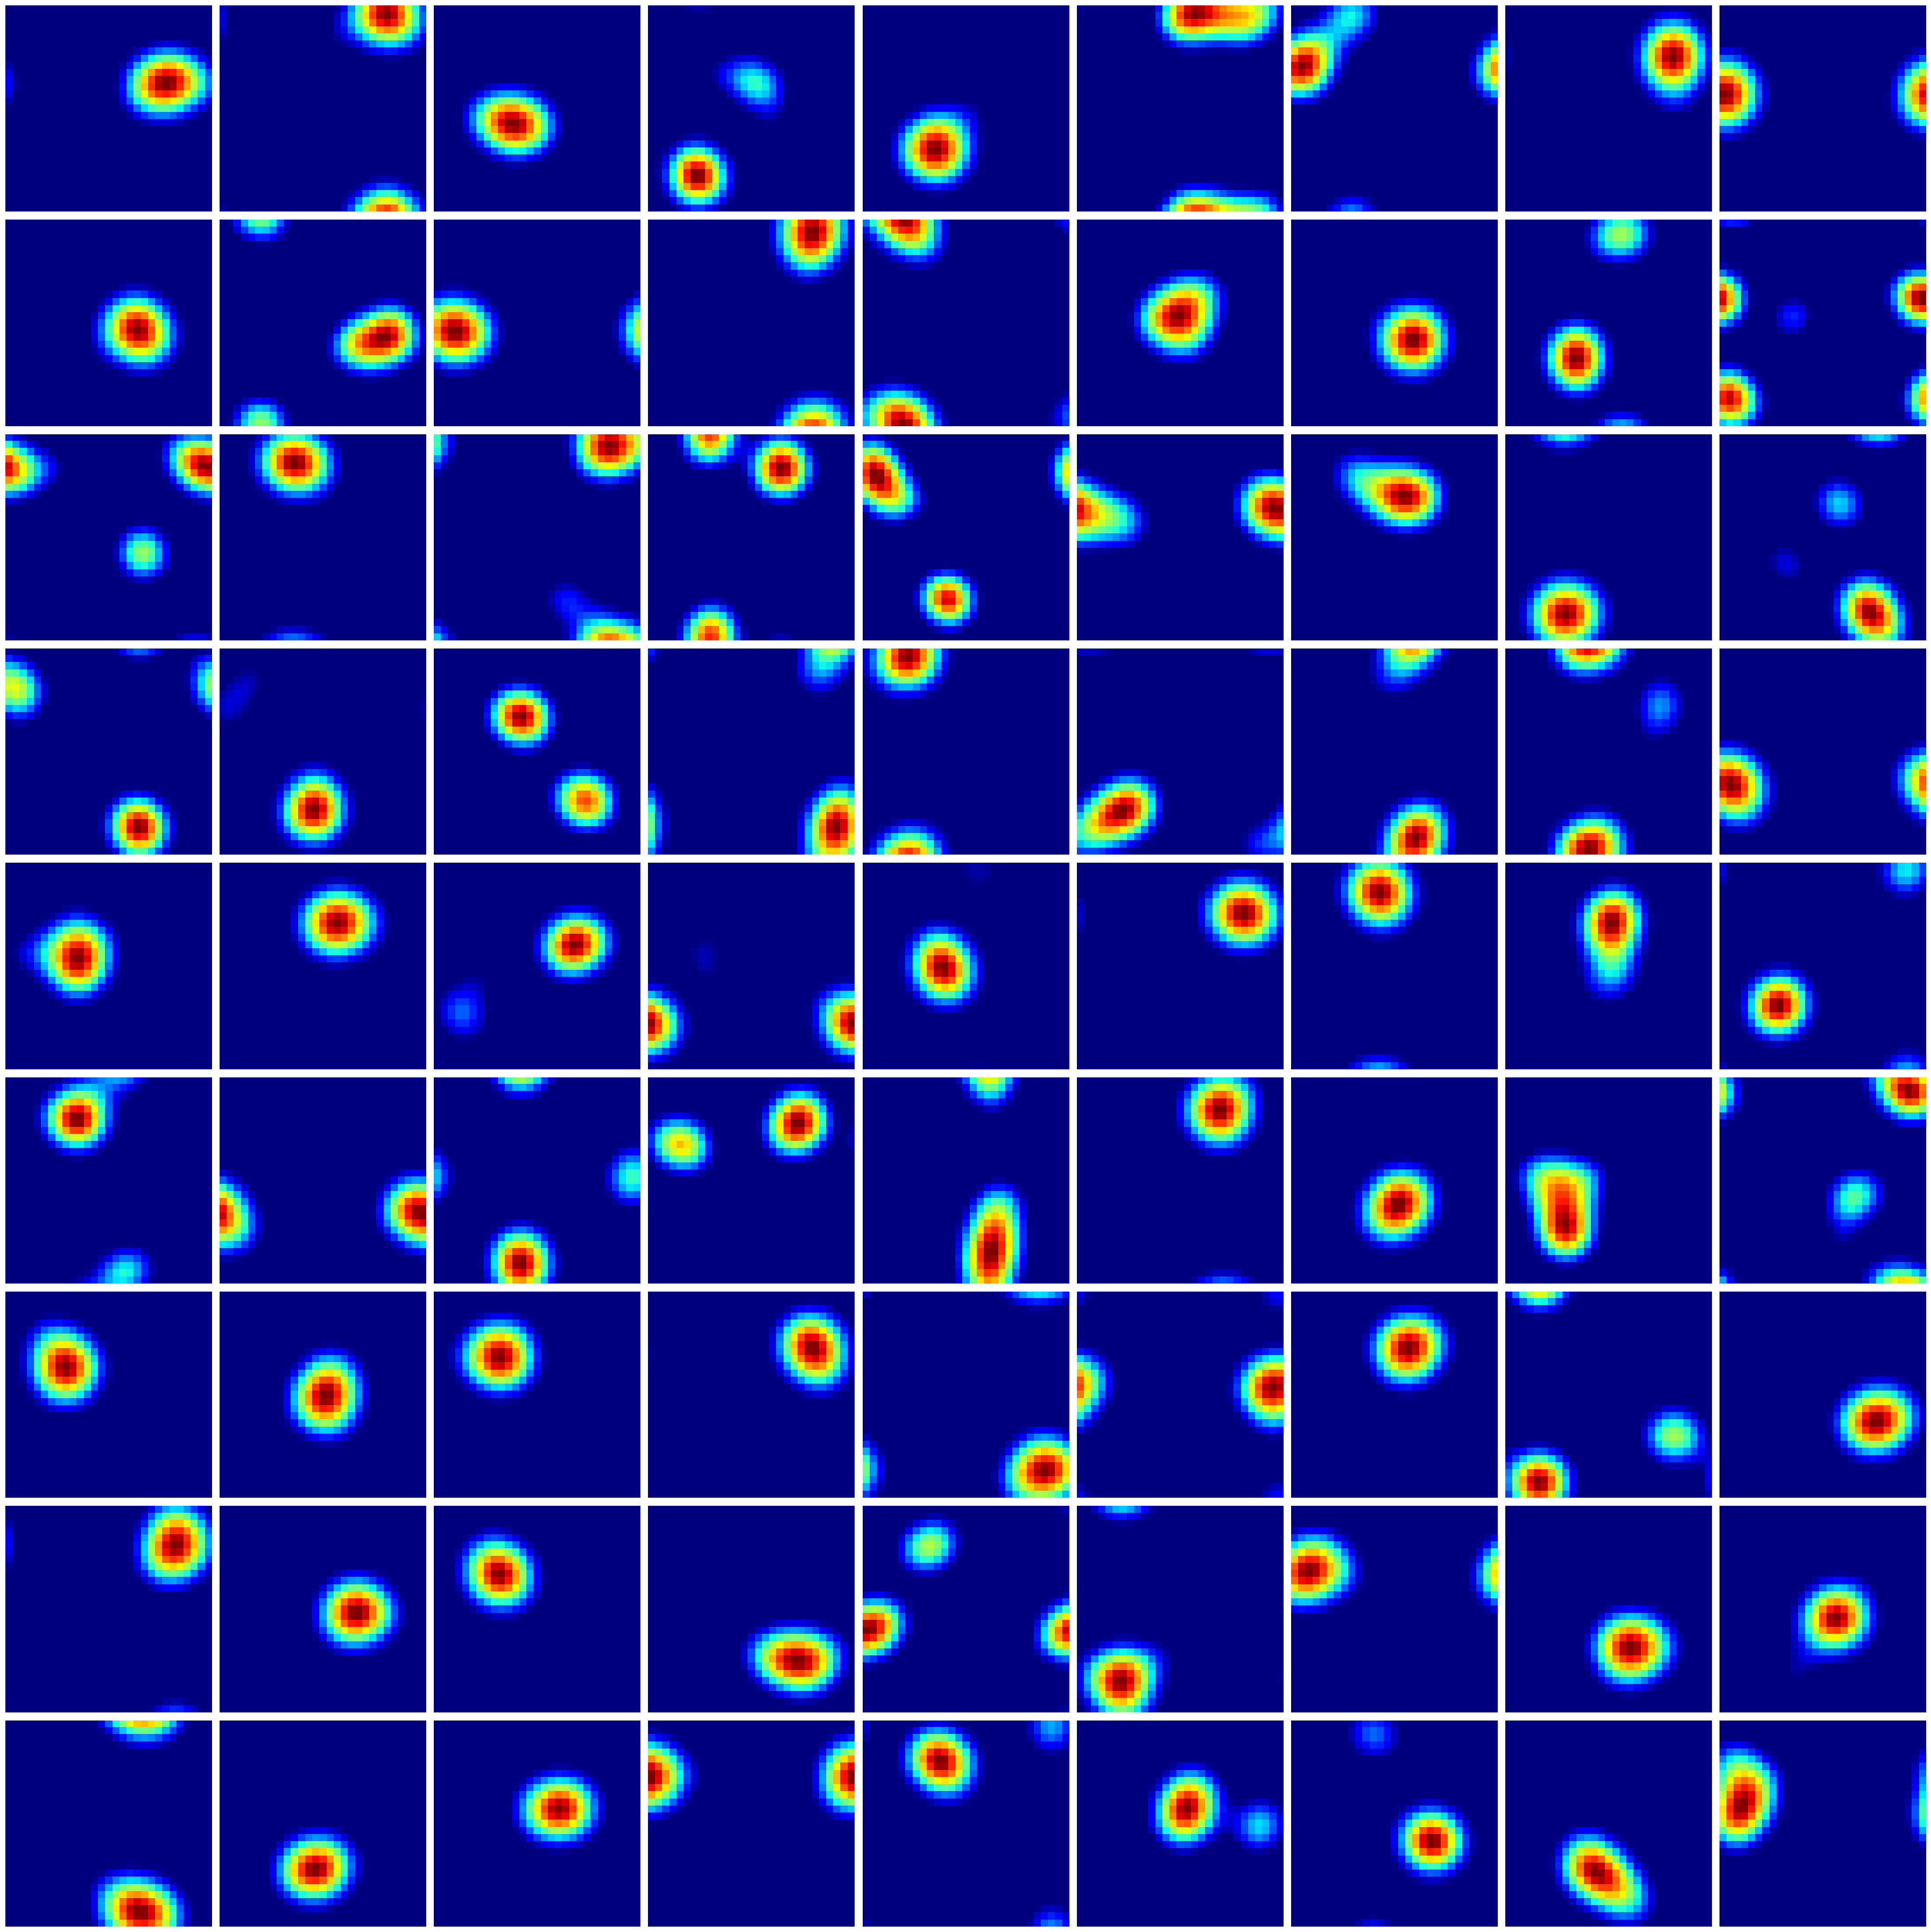

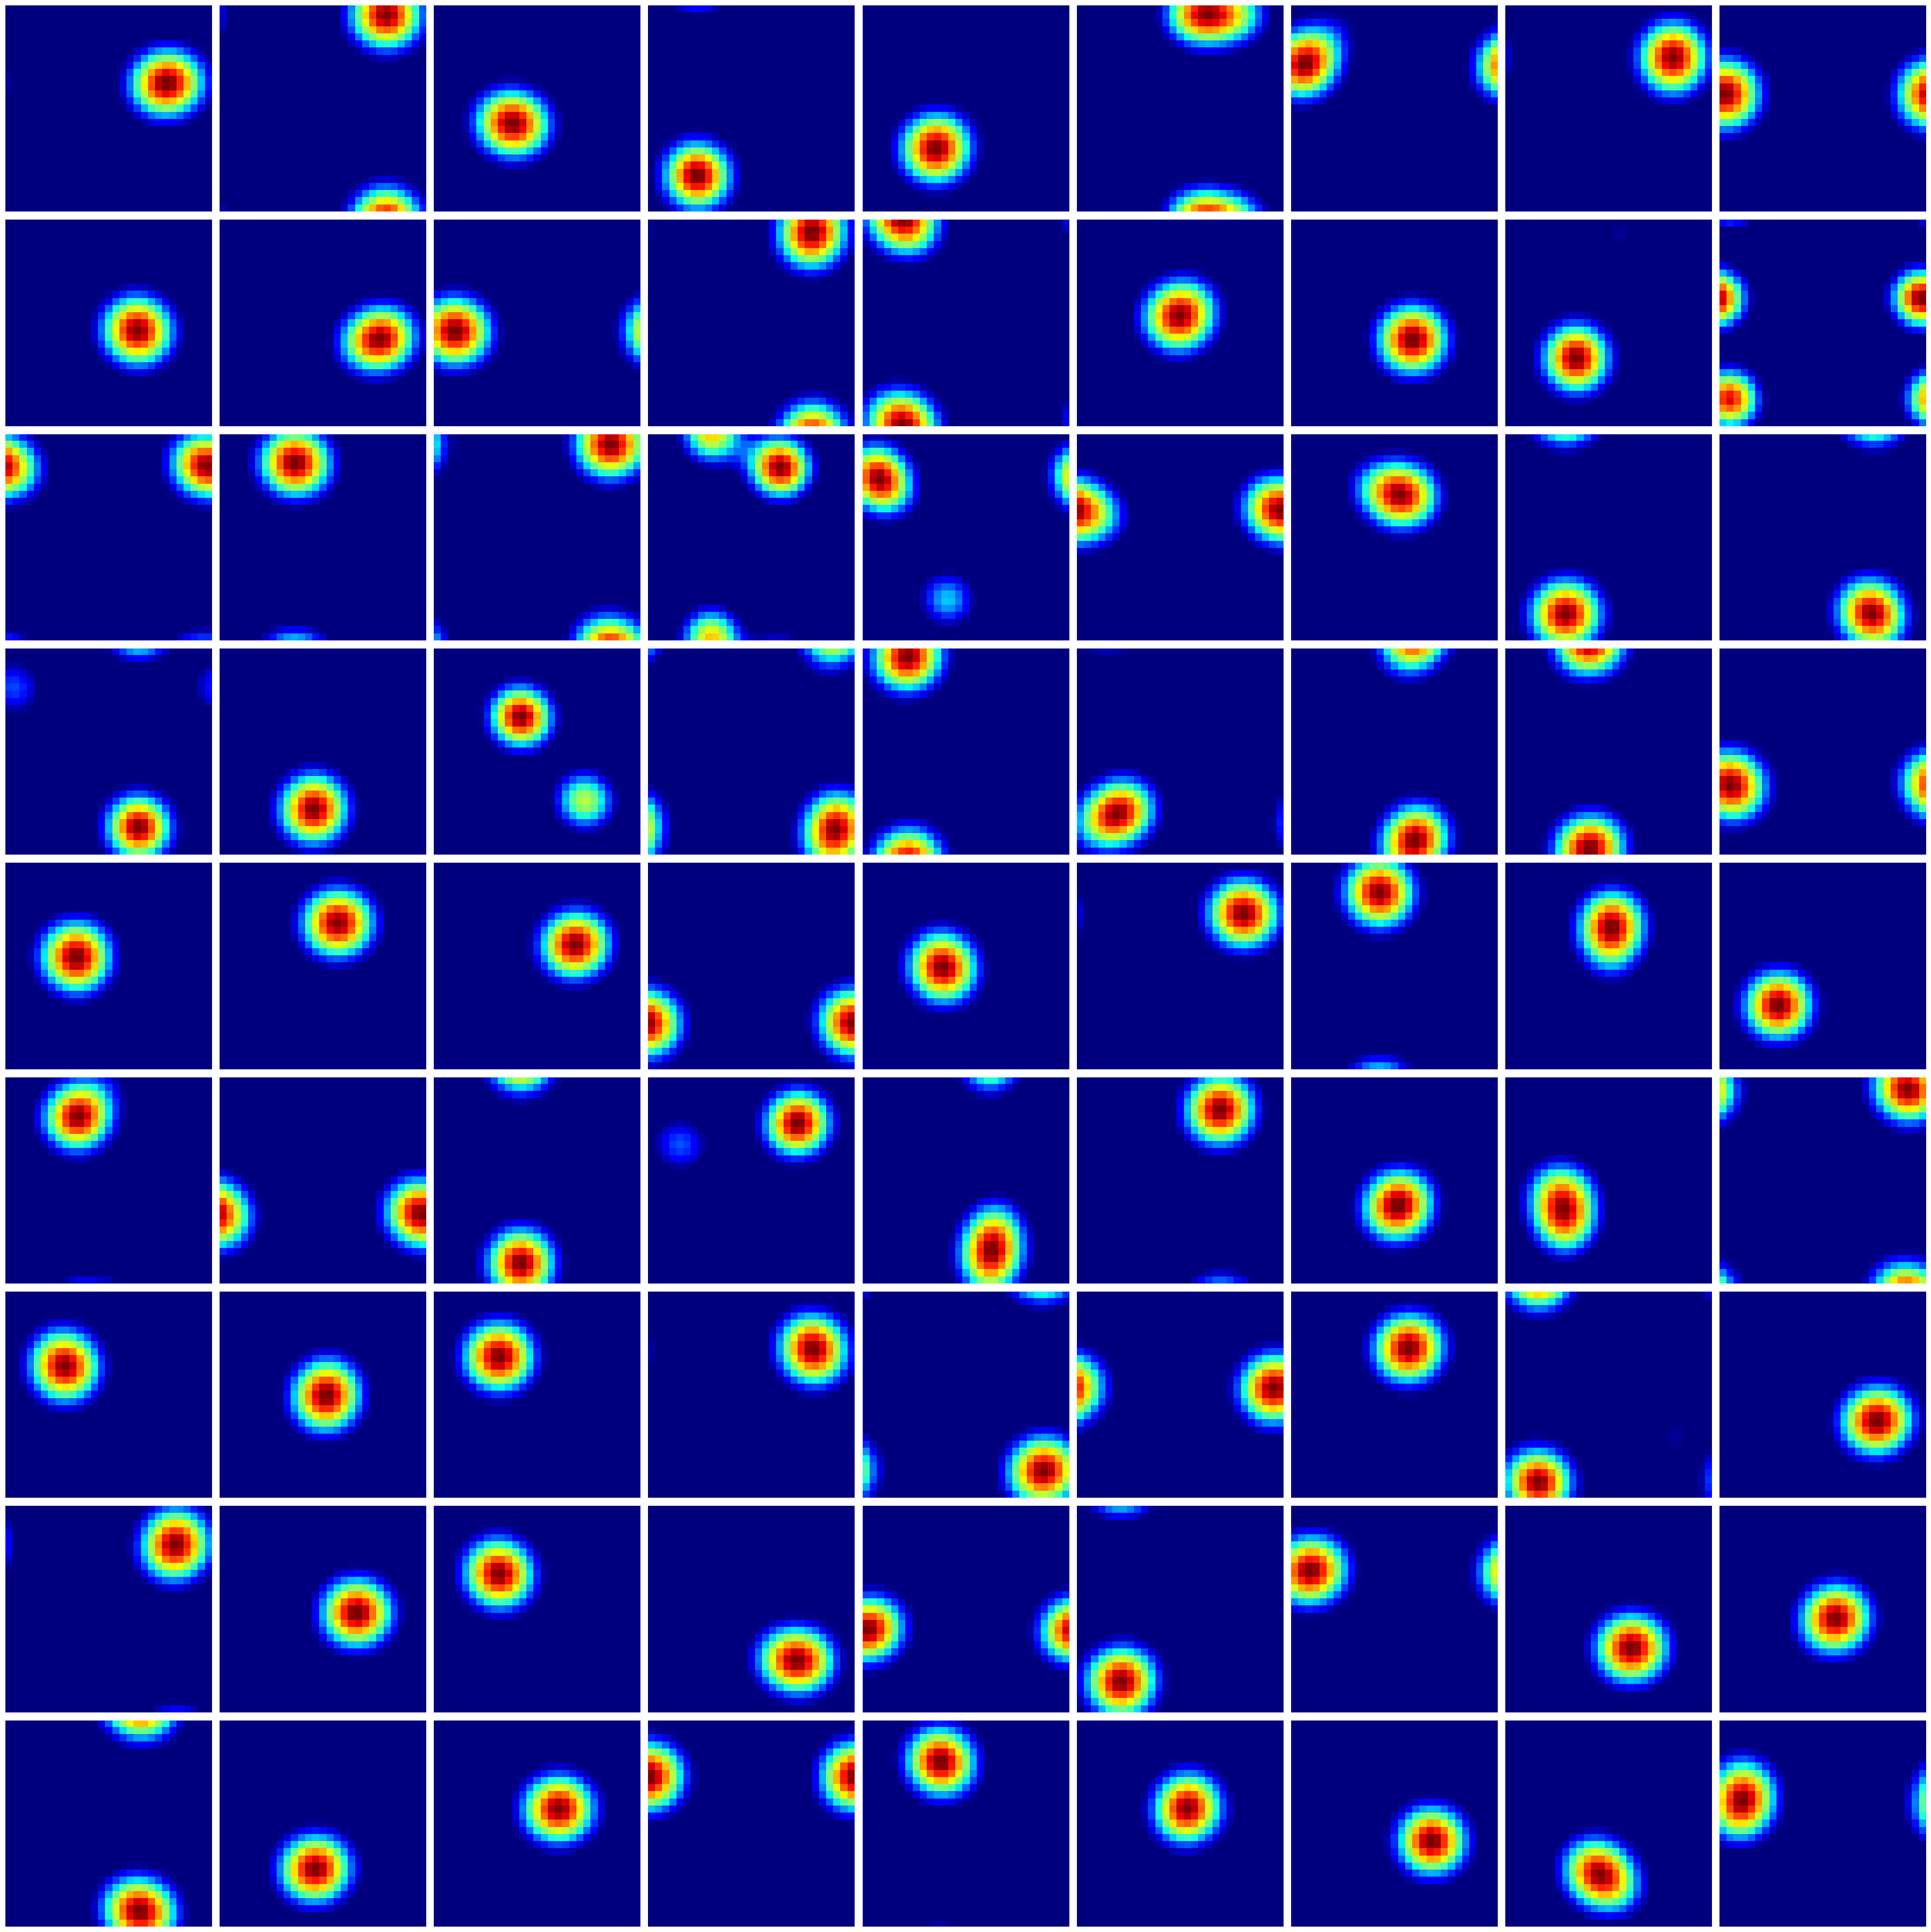

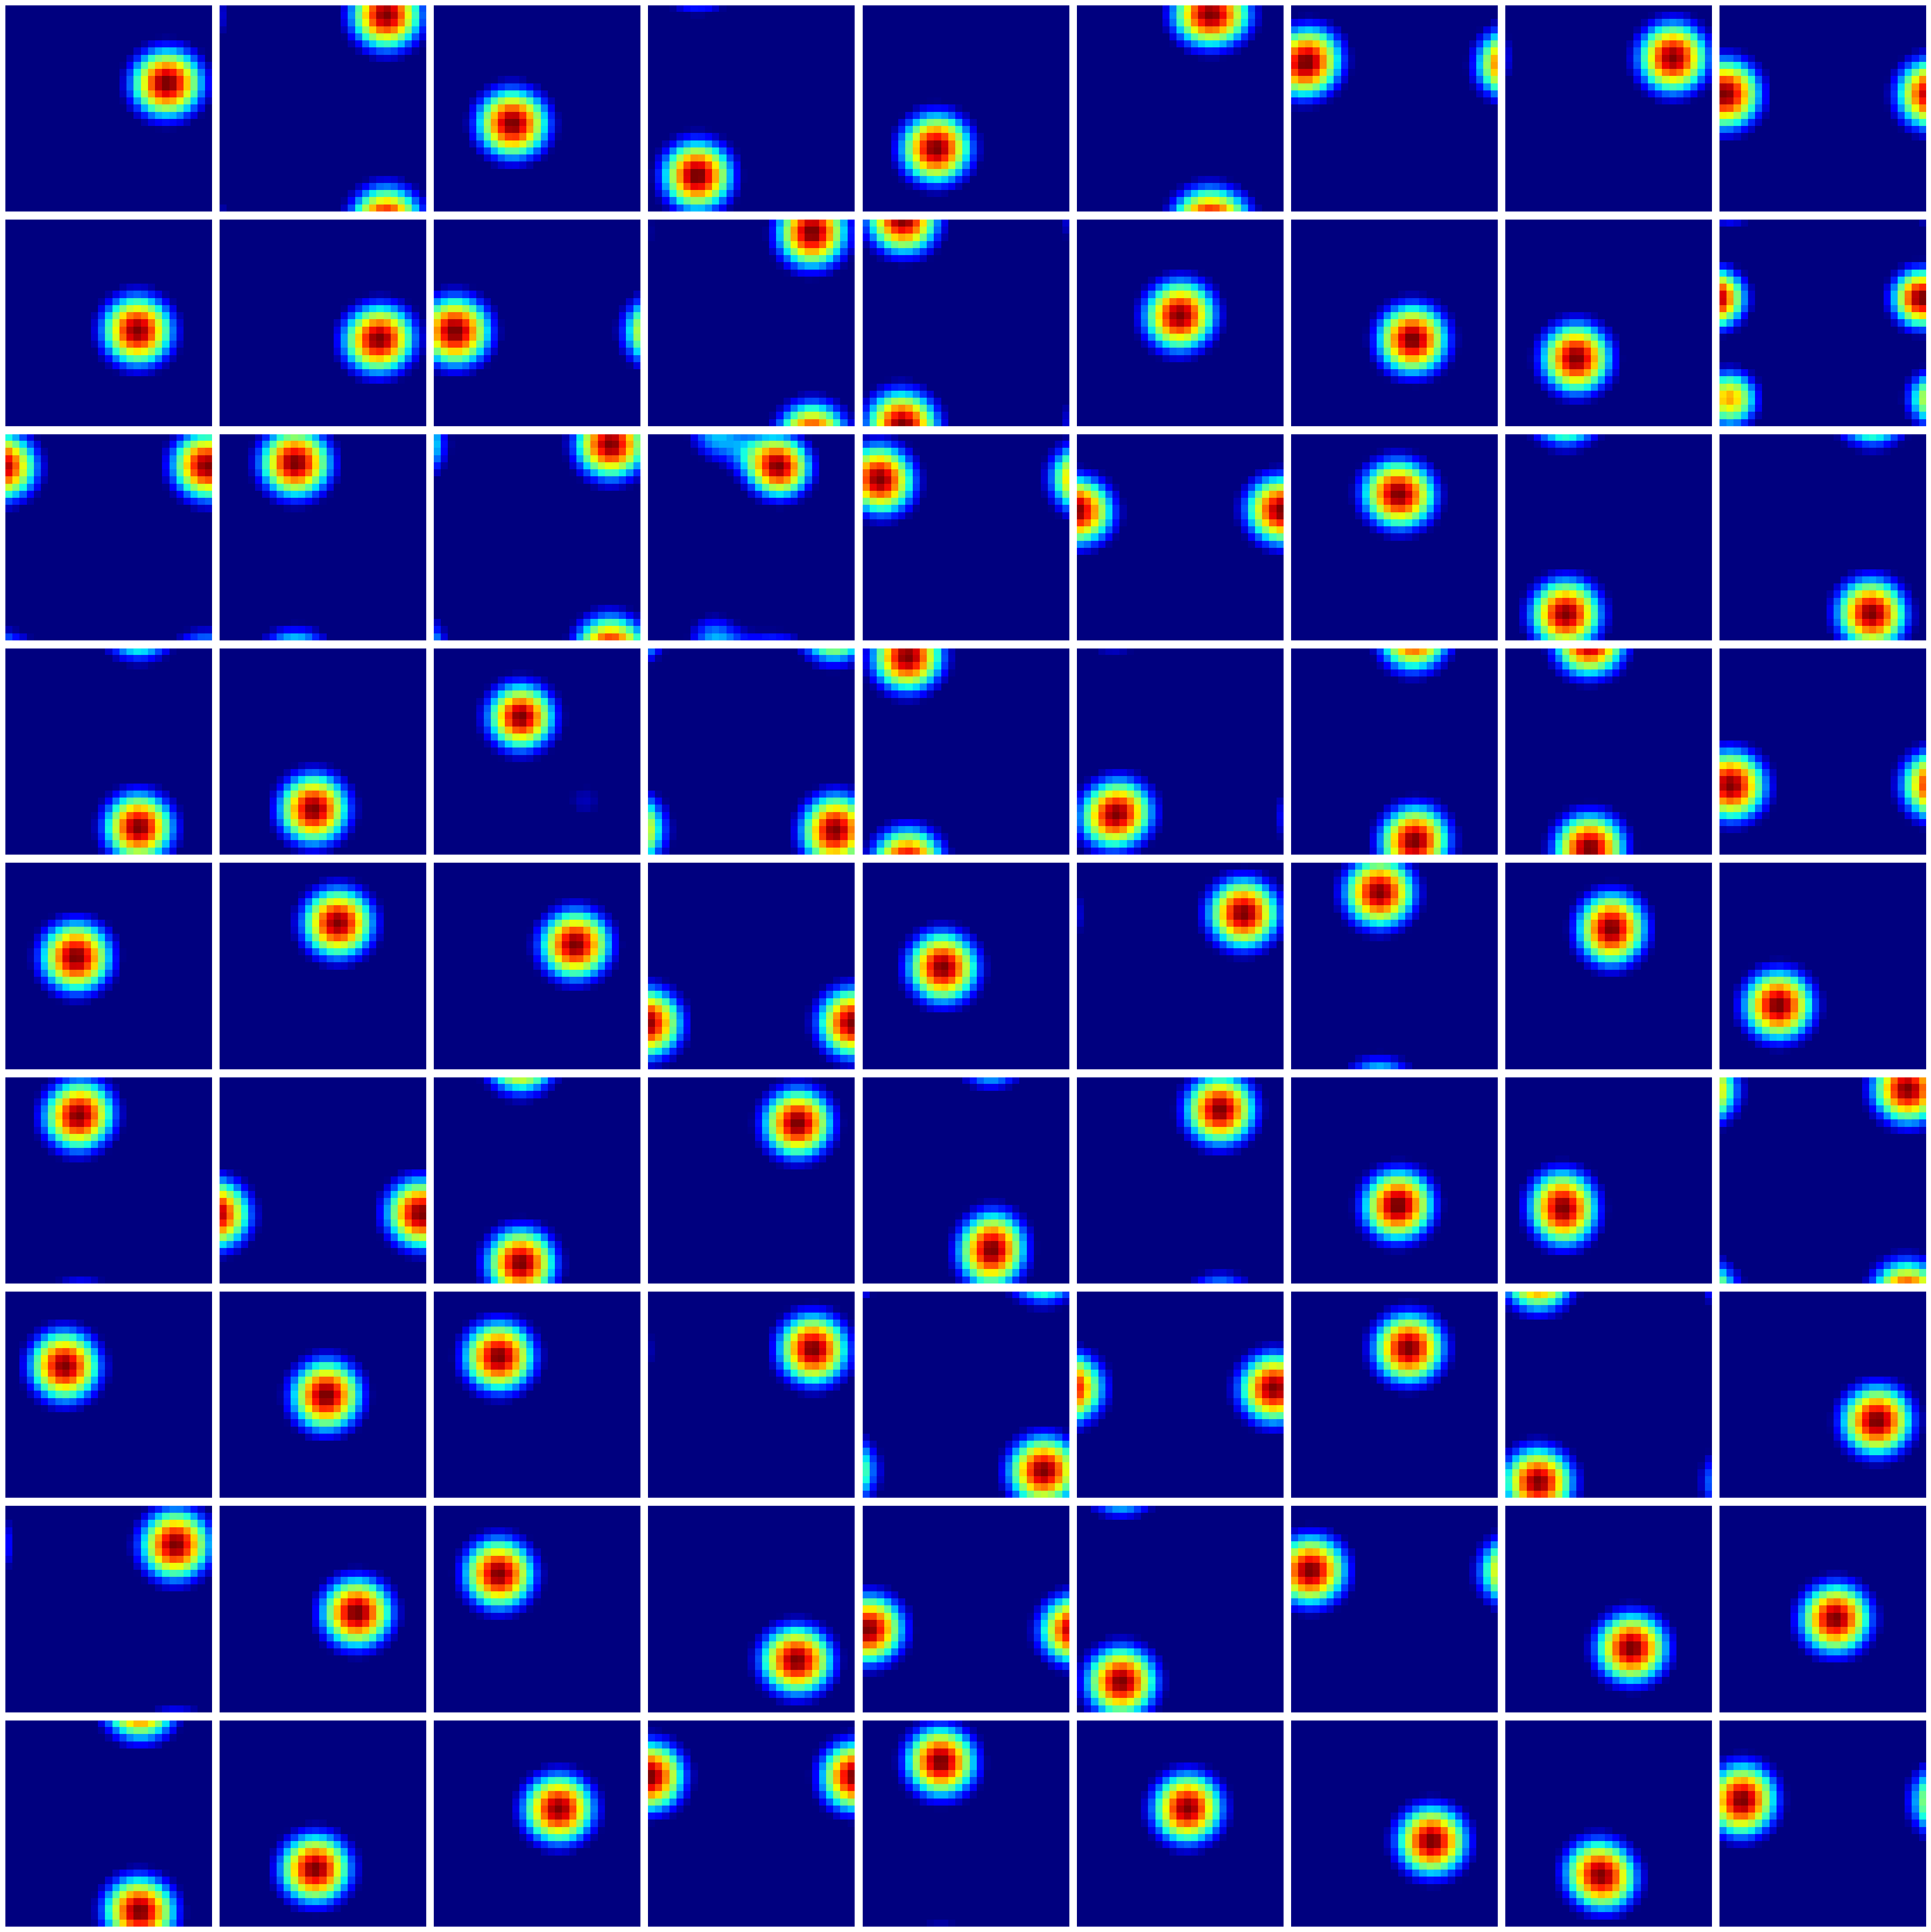

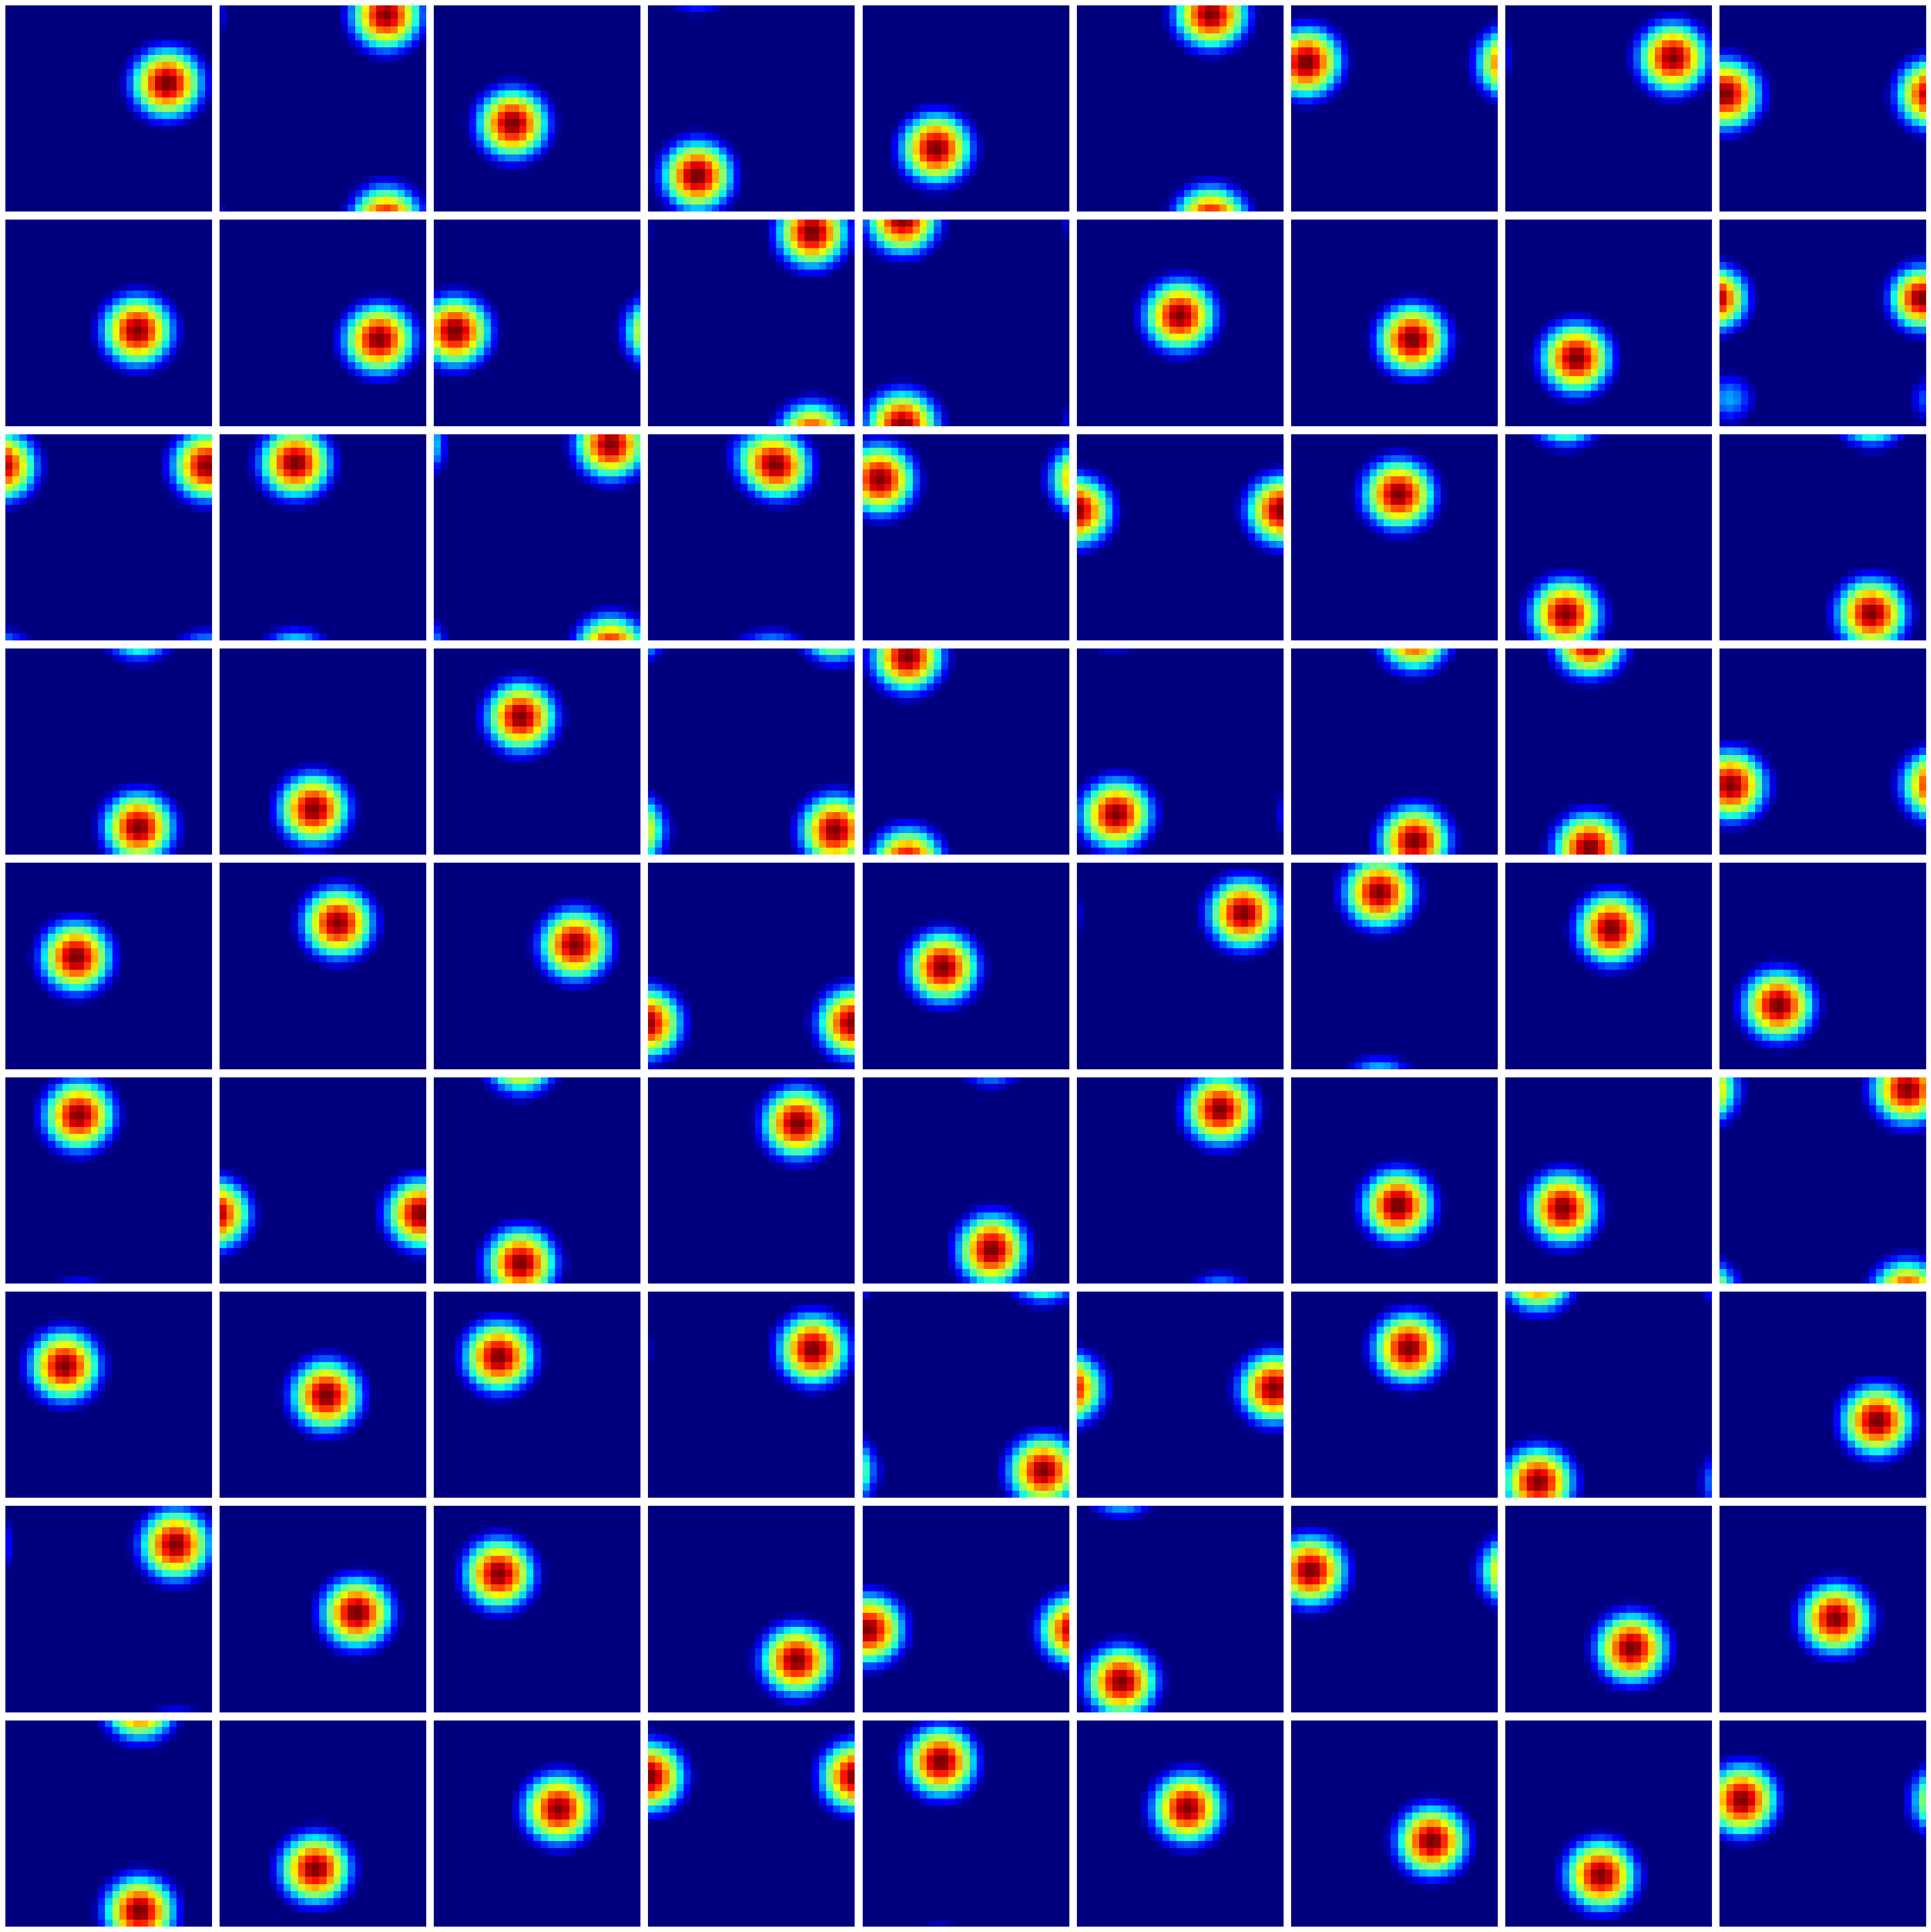

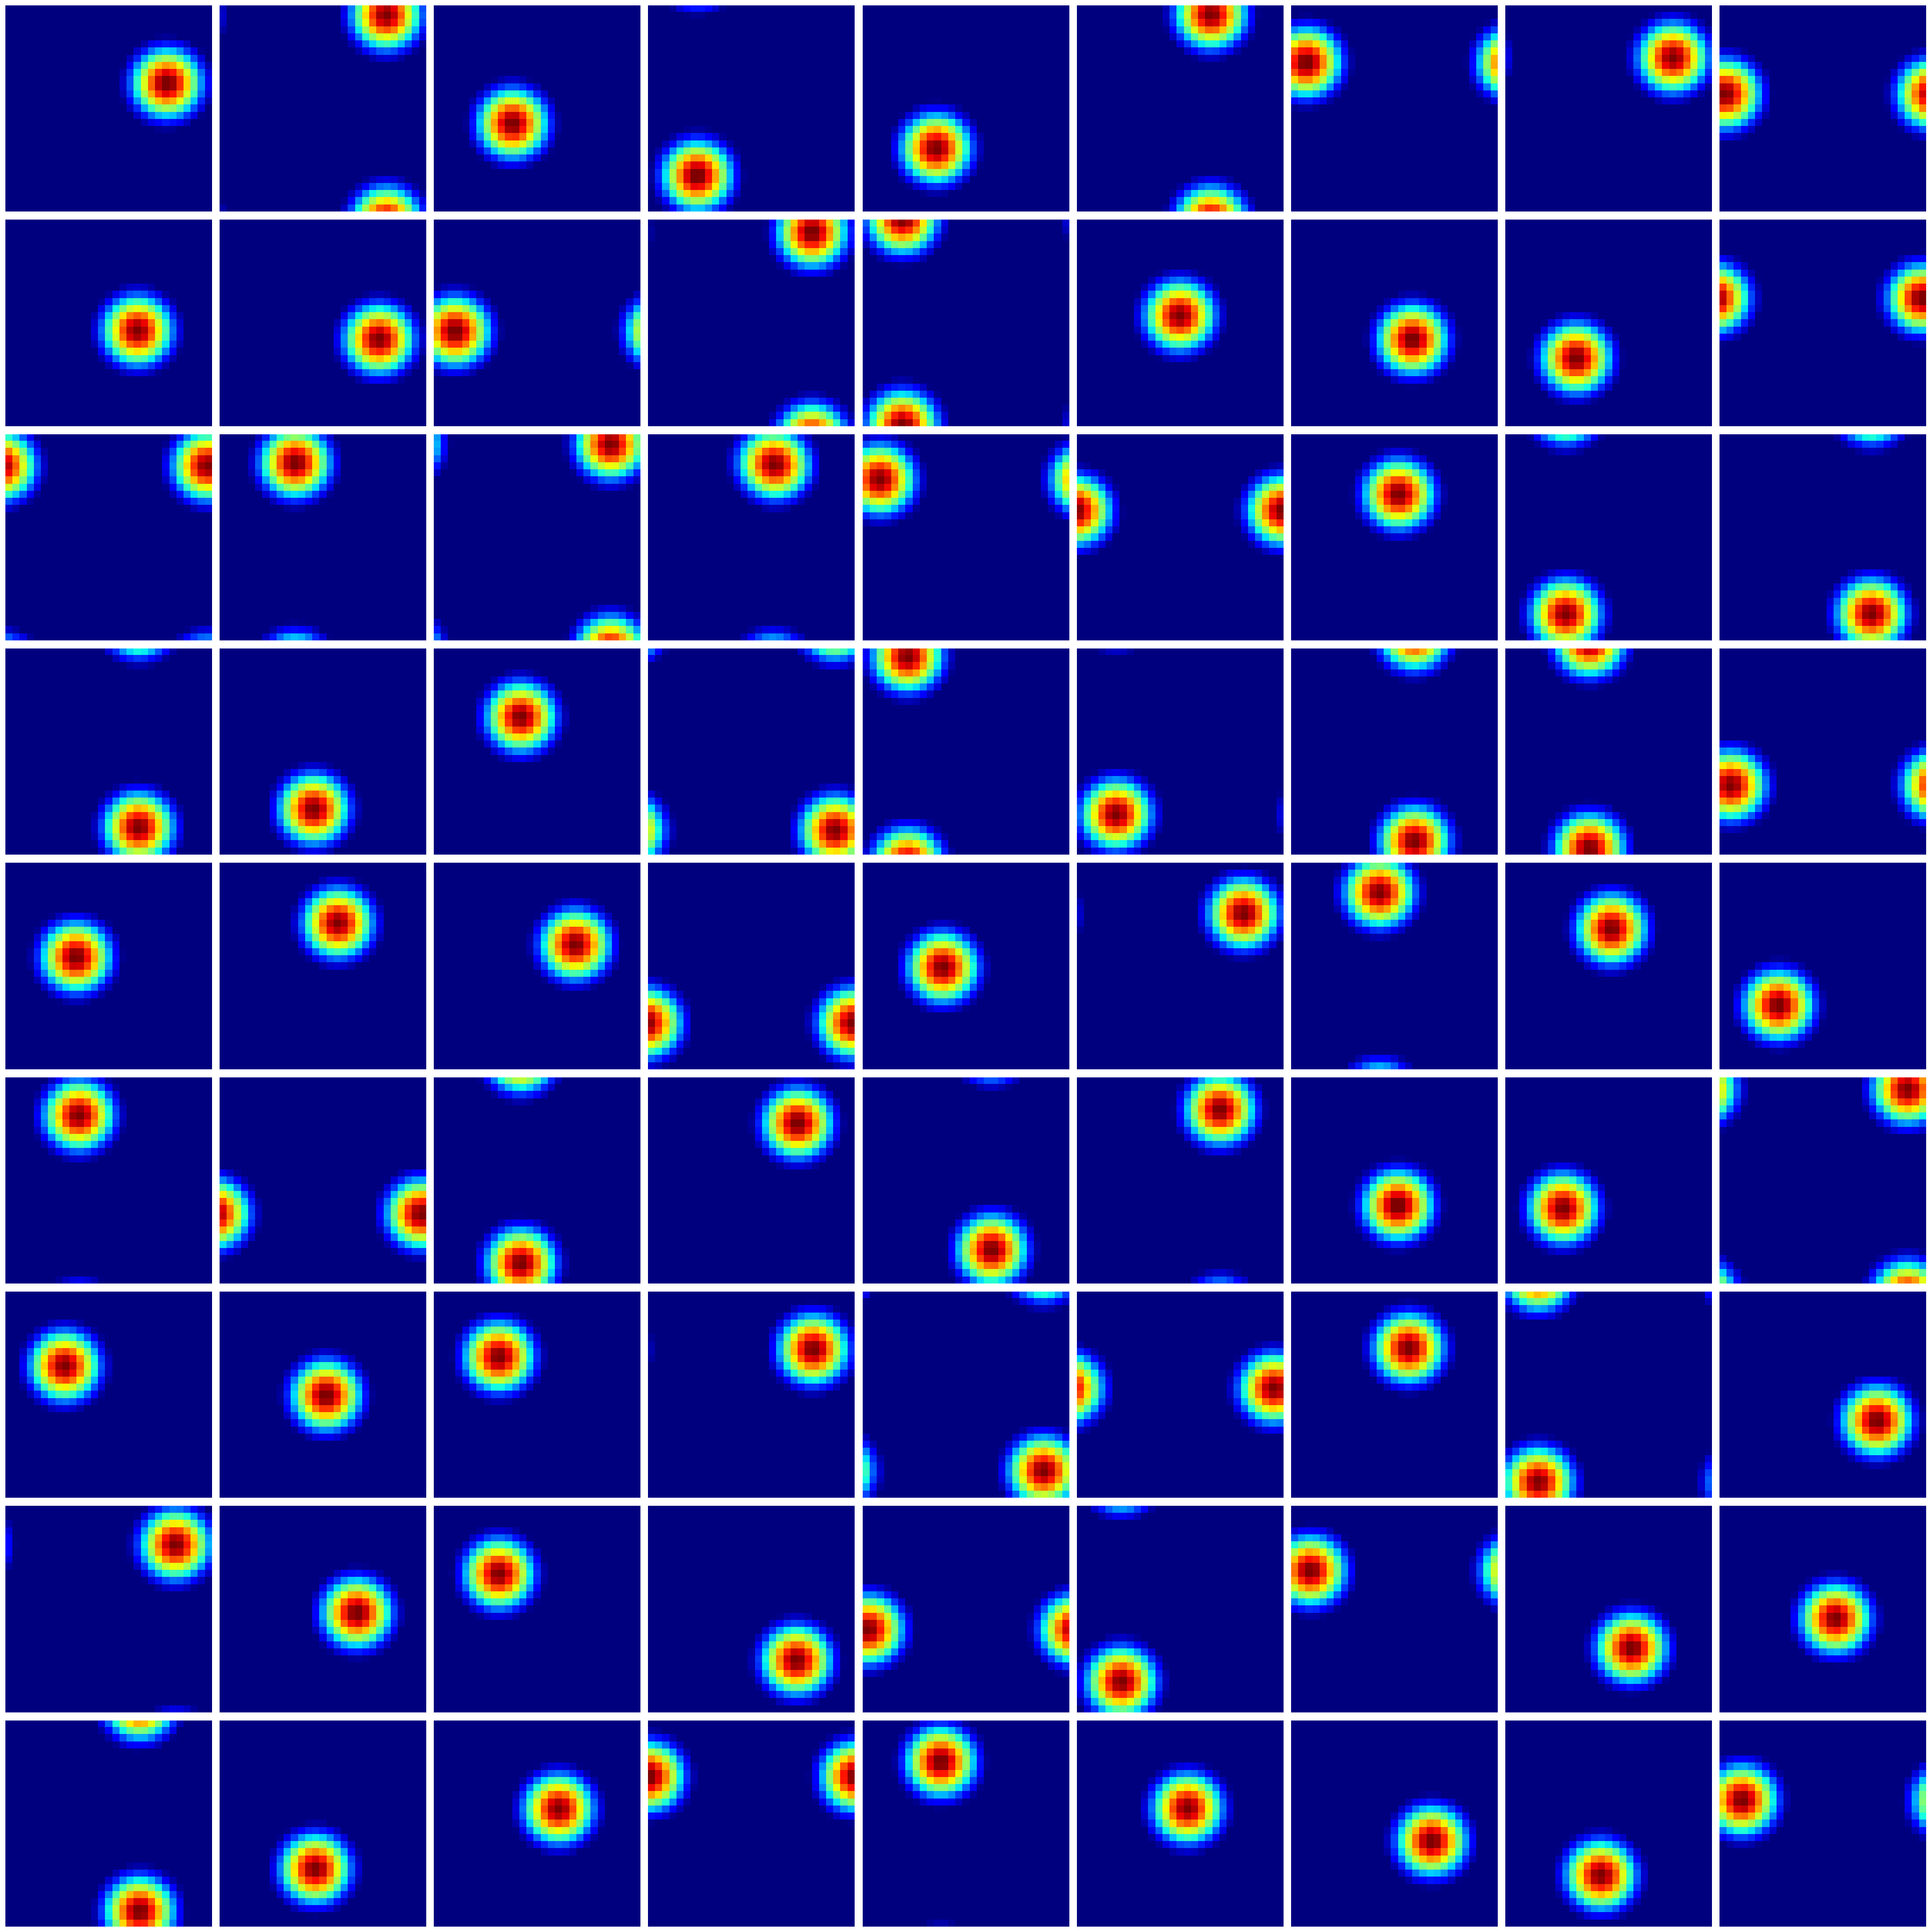

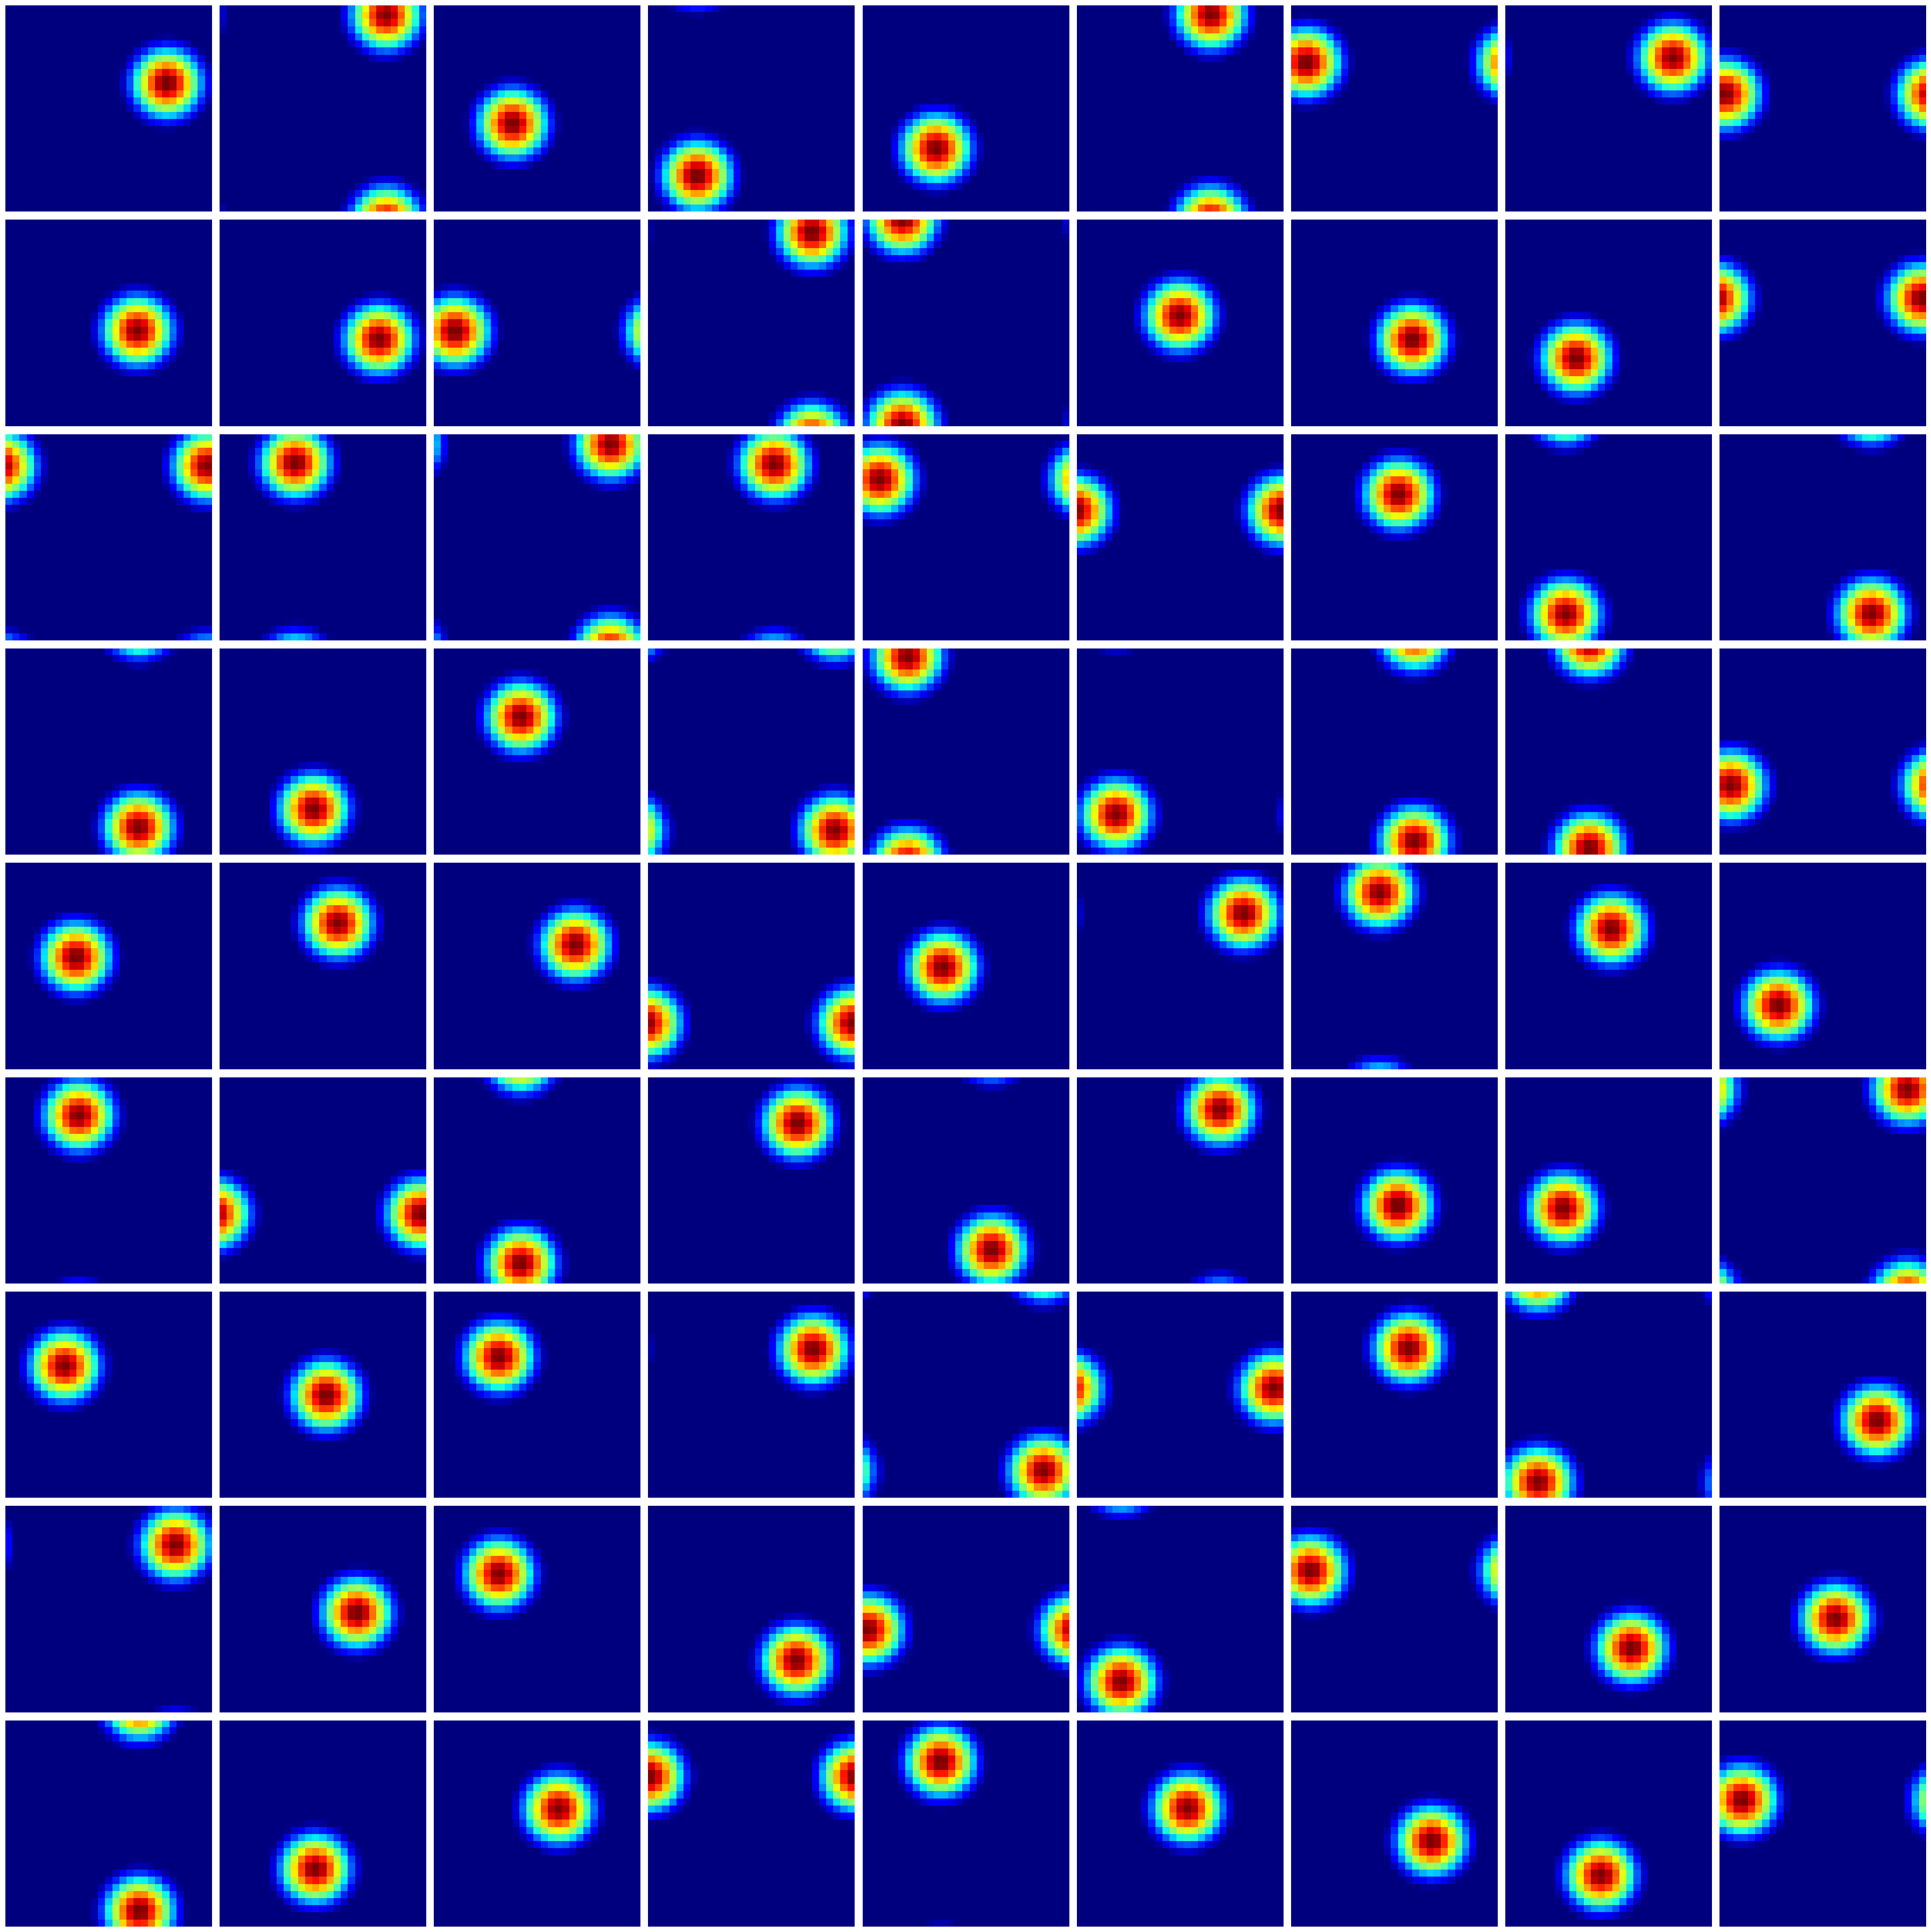

KeyboardInterrupt: 

In [9]:
## single cell optimisation ## 
# Symmetry-breaking nonlinearity (relu)

def convolve_with_C(g, Ctilde):
    '''
    Convolves the input g with the kernel C
    '''
    gtilde = np.fft.fft2(g, [res, res])
    gconv = np.real(np.fft.ifft2(gtilde*Ctilde))
    gconv = np.roll(np.roll(gconv, res//2+1, axis=1), res//2+1, axis=2)
    
    return gconv

def relu(x):
    return np.maximum(x,0)

Ng = 9**2
n_plot_rows = int(np.sqrt(Ng))
T = 1000
lr = 5e-3

#NOTE THAT THE VARIABILITY IN ORIENTATION / PHASE DEPENDS ON INITIAL RANDOM SEED
G = np.random.randn(Ng,res,res) * 1e-8
#repeated_init = np.random.randn(res,res)*1e-8
#G = np.stack([ repeated_init for _ in range(Ng)])

for i in range(T):
    G +=lr*(-G + convolve_with_C(G, Ctilde))
    G = relu(G)
    if i%100==99:
        fig, ax = plt.subplots(n_plot_rows,Ng//n_plot_rows, 
                               figsize = (4*Ng//n_plot_rows,4*n_plot_rows))
        for i, axis in enumerate(ax.flatten()):
            axis.imshow(G[i], cmap = 'jet')
            axis.axis('off')
        fig.tight_layout()
        plt.show()
        
    if np.all(np.isnan(G[0])):
        print(f'all NaN at iteration {i}')
        break
            

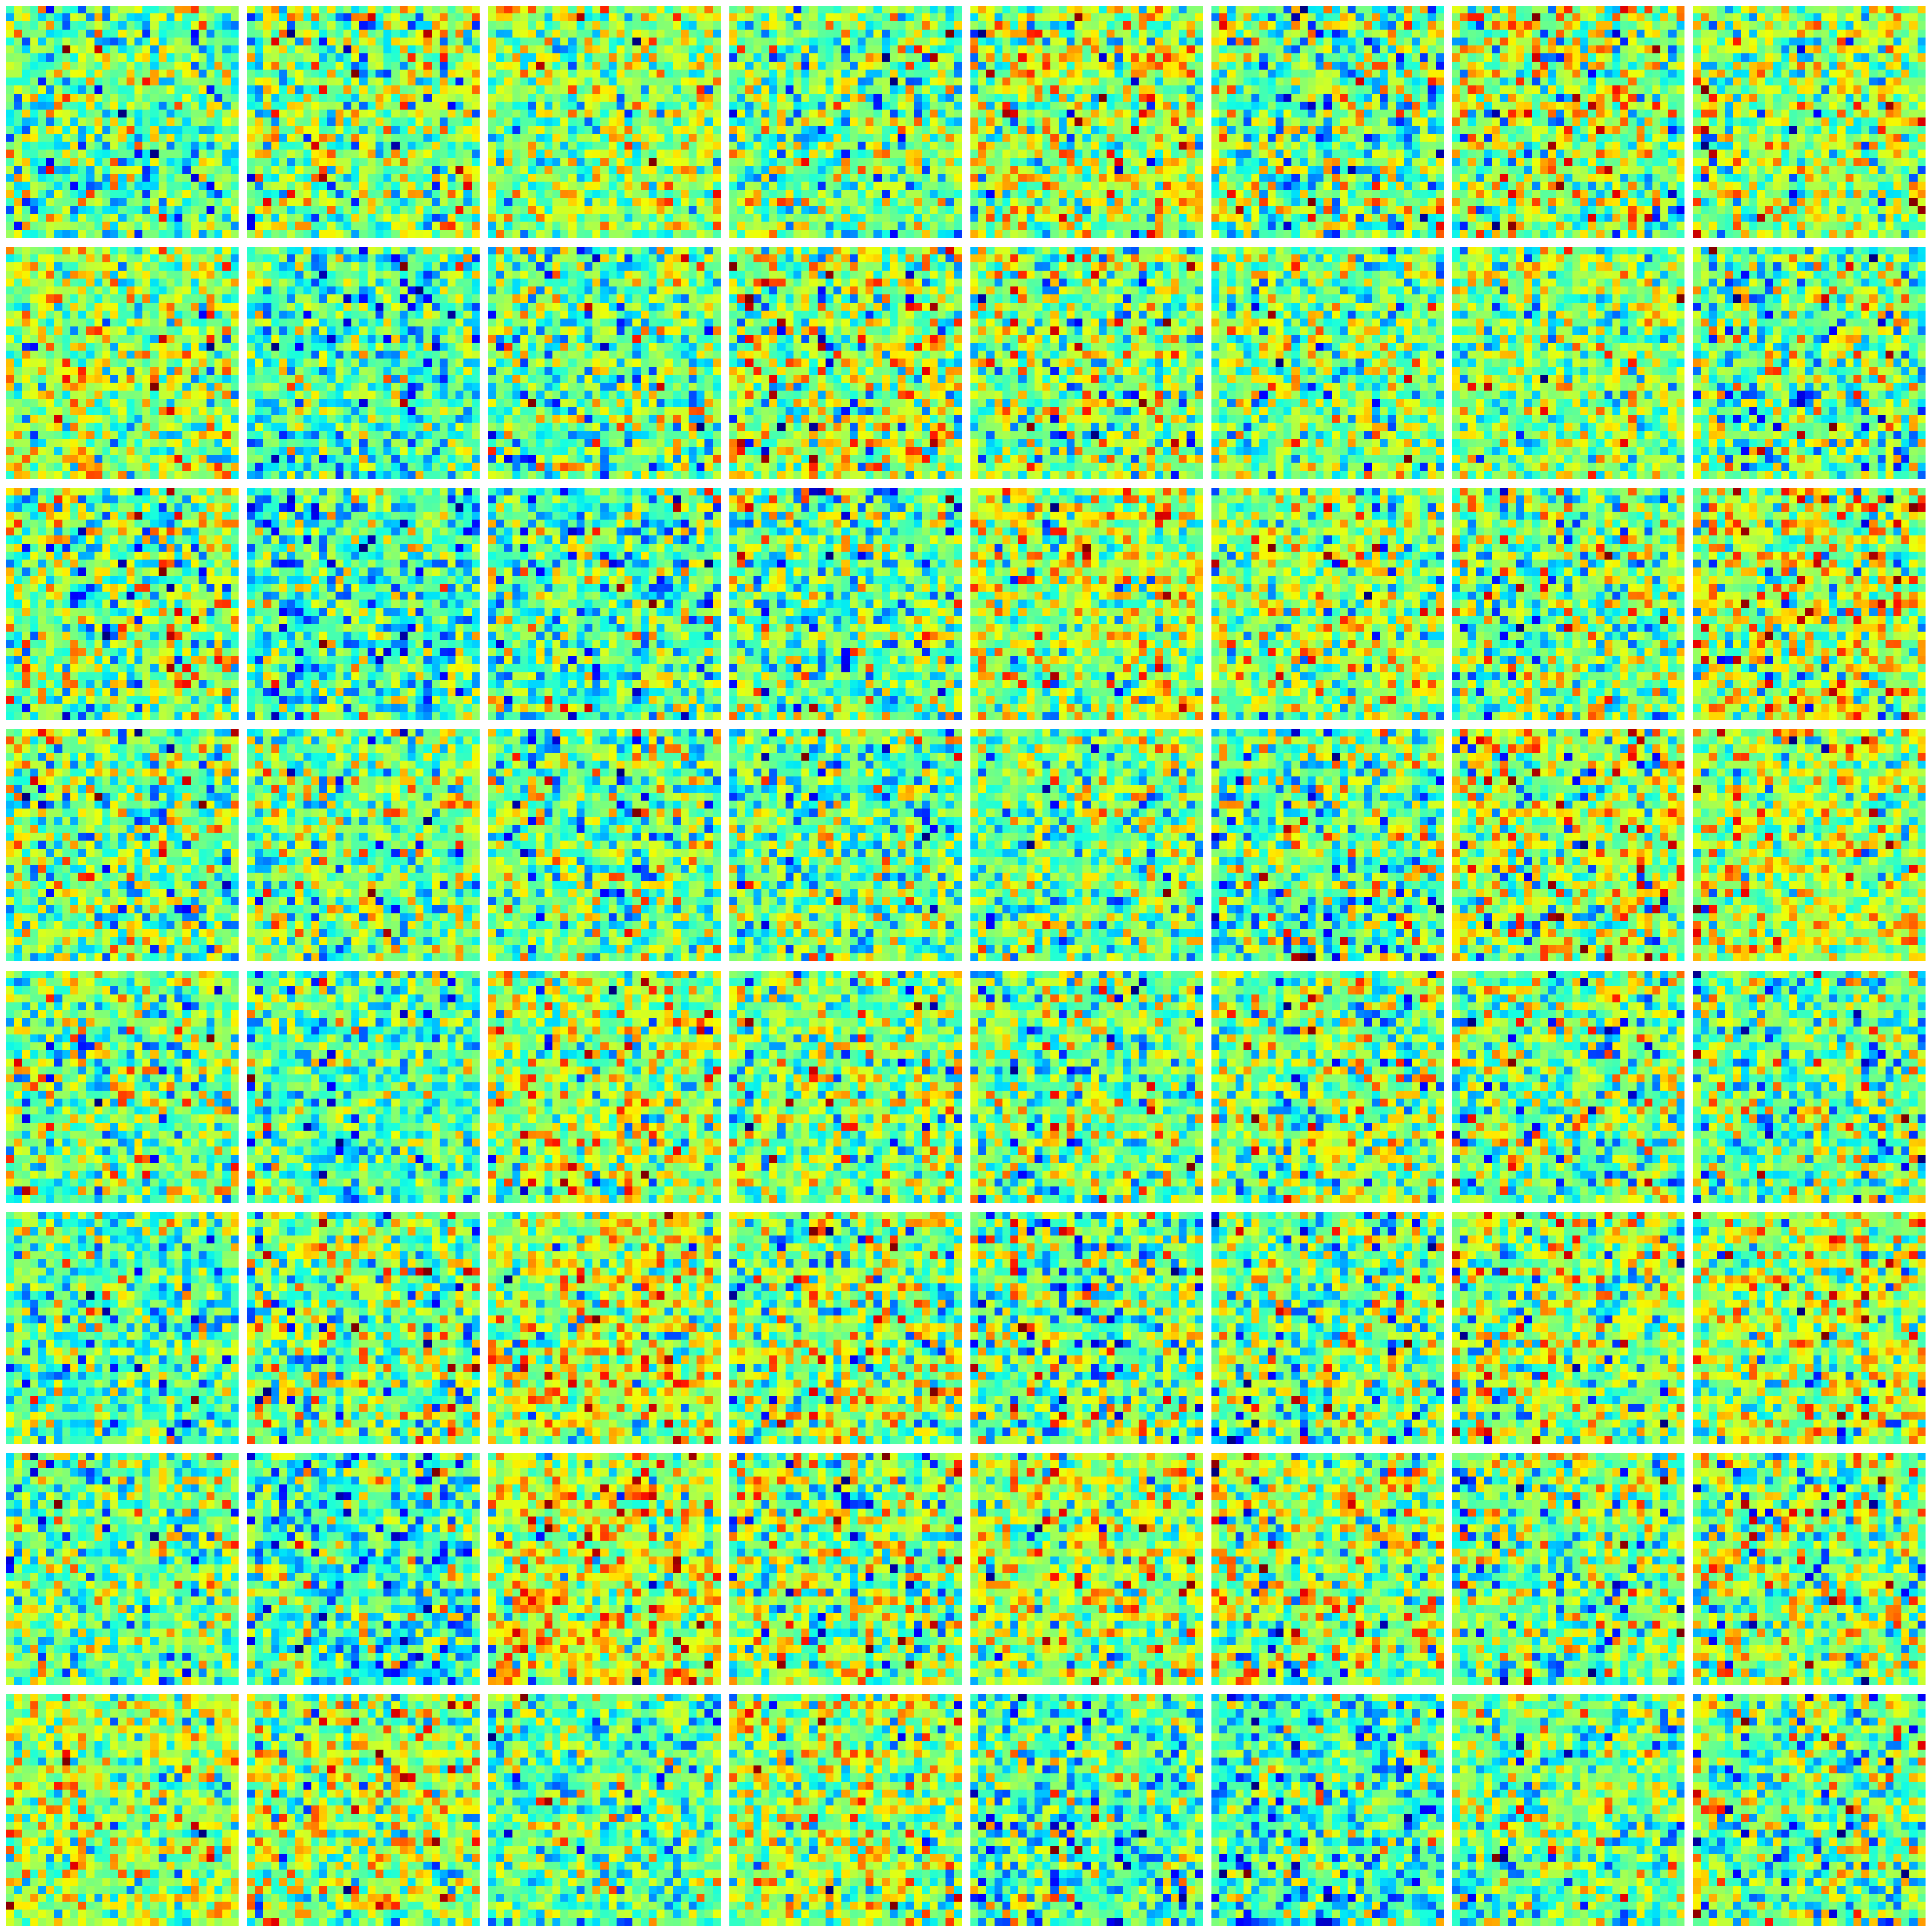

In [10]:
## population optimisation ## 

def phi(x,r):
    return np.maximum(r*x,0)

Ng = 8**2
n_plot_rows = int(np.sqrt(Ng))
r = 30
T = 5000
lr = 1.3e-6
G = np.random.randn(Ng,res,res) * 1e-8
#repeated_init = np.random.randn(res,res)*1e-8
#G = np.stack([ repeated_init for _ in range(Ng)])

for i in range(T):
    H = convolve_with_C(G, Ctilde)
    #H = phi(H,r) #this is not in the original code, but could be helpful to integrate non-negativity in the orthogonalisation penalty?
    Hr = H.reshape([Ng, -1])
    Gr = G.reshape([Ng, -1])
    oja = Gr.T.dot(np.tril(Gr.dot(Hr.T))).T.reshape([Ng,res,res])
    G_relu = phi(G,r)
    #we should balance constraints
    balance_scalar = np.abs(H-oja).max()/np.abs(G_relu).max() # 1 #np.min([H.max(),oja.max()])/G_relu.max() #(np.abs(H-oja).max()/np.abs(G_relu).max())
    G += lr * (H - oja + balance_scalar*G_relu) 
    
    if i%200==199:
        fig, ax = plt.subplots(n_plot_rows,Ng//n_plot_rows, 
                               figsize = (4*Ng//n_plot_rows,4*n_plot_rows))
        for i, axis in enumerate(ax.flatten()):
            axis.imshow(np.flip(G)[i], cmap = 'jet')
            axis.axis('off')
        fig.tight_layout()
        plt.show()
        break
    if np.all(np.isnan(G[0])):
        print(f'all NaN at iteration {i}')
        break

### Successor features (thanks RatInABox)

In [ ]:
# we want to make a dataframe with successor features 
# following successor features demo:
import ratinabox as riab
from ratinabox.Neurons import PlaceCells
from ratinabox.contribs.SuccessorFeatures import SuccessorFeatures
from tqdm.auto import tqdm # progress bar
from GridModels.code.RNNs.vel2pc_RNN import options

%load_ext autoreload
%autoreload 2

SuccessorFeatures.get_all_default_params()

# set up rat and box
np.random.seed(42) #reproducible place cell locations
box = riab.Environment(params = {'scale':options.environment_scale})
rat = riab.Agent(box, params={"dt":options.framerate})
place_cells = PlaceCells(rat, params = {"n":options.Np,
                                        "description":options.pc_type,
                                        "widths":options.place_cell_rf})
SFs = SuccessorFeatures(rat, params={"features": place_cells,
                                    "input_layers": [place_cells],
                                    'tau':10, #predictive time horizon
                                    'eta':0.01,
                                    })
np.random.seed() #completely random trajectories
true_trajectory = navigation_activity_df # use the same trajectory as previous simulation
for i in tqdm(range(options.n_steps)):
        rat.update()
        if true_trajectory is not None:
            # if we have a real trajectory, we use it to set the rat's position
            rat.history['pos'][-1] = true_trajectory['centroid_position'].values[i]
            rat.history['vel'][-1] = true_trajectory['velocity'].values[i]
            rat.history['head_direction'][-1] = [true_trajectory['head_direction'].x.values[i], true_trajectory['head_direction'].y.values[i]]
        place_cells.update()
        SFs.update()
        SFs.update_weights()    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/100000 [00:00<?, ?it/s]

: 

In [ ]:
# reformat as activity df

import pandas as pd

# now save in a format easy to read and store, consistent with our real data.
nav_rates_dict = {}
nav_rates_dict['time'] = rat.history['t']
nav_rates_dict['centroid_position.x'] = [p[0] for p in rat.history['pos']]
nav_rates_dict['centroid_position.y'] = [p[1] for p in rat.history['pos']]
nav_rates_dict['velocity.x'] = [v[0] for v in rat.history['vel']]
nav_rates_dict['velocity.y'] = [v[1] for v in rat.history['vel']]
nav_rates_dict['head_direction.x'] = [v[0] for v in rat.history['head_direction']]
nav_rates_dict['head_direction.y'] = [v[1] for v in rat.history['head_direction']]
nav_rates_dict['head_direction.degrees'] = np.rad2deg([np.arctan2(v[1],v[0]) for v in rat.history['head_direction']])
for place_cell in range(options.Np):
    nav_rates_dict[f'firingrate.place_cell_{place_cell}'] = [x[place_cell] for x in place_cells.history['firingrate']]
navigation_rates_df = pd.DataFrame(nav_rates_dict)
#make it multicolumn index !
navigation_rates_df.columns = pd.MultiIndex.from_tuples([
    tuple(col.split('.')) if '.' in col else (col, '') 
    for col in navigation_rates_df.columns])